In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
dir_path='../control_transition'
sys.path.append(dir_path)

In [4]:
from plot_utils import generate_params, load_zip_json, convert_pd

In [5]:
import matplotlib
matplotlib.rcParams['figure.dpi'] =300

In [6]:
L_list=[10,20,30,40]
# L_list=[30]
params_list=[
({'nu':0,'de':1,},
{
'p_proj':[0,],
'sC':np.arange(0,500),
'sm':[0],
'L':[L],
# 'maxdim':[2048,4096,],
# 'maxdim':[2**13,],
'maxdim':[256,],
'cutoff': [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-8,1e-10,1e-15],
# 'p_ctrl':np.linspace(0,1,21),
'p_ctrl':np.linspace(0,.95,20),
}
)
 for L in L_list]

In [12]:
data_MPS_0_T_dict={'fn':set()}
for fixed_params,vary_params in params_list:
    L= vary_params['L'][0]
    data_MPS_0_T_dict=generate_params(
        fixed_params=fixed_params,
        vary_params=vary_params,
        fn_template='MPS_({nu},{de})_L{L}_pctrl{p_ctrl:.3f}_pproj{p_proj:.3f}_sC{sC}_sm{sm}_maxdim{maxdim}_cutoff{cutoff:.1e}.json',
        fn_dir_template='./',
        input_params_template='',
        load_data=load_zip_json,
        filename=None,
        filelist=None,
        load=True,
        data_dict=data_MPS_0_T_dict,
        zip_fn=f'./MPS_0-1_evo_L{L}.zip'
    )
df_MPS_0_T=convert_pd(data_MPS_0_T_dict,names=['Metrics','cutoff','sm','sC','maxdim','p_ctrl','L','p_proj'])

generate_params: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90000/90000 [09:52<00:00, 151.81it/s]


In [165]:
df_MPS_0_T.to_pickle('./MPS_0-1_evo_L.pickle')

In [8]:
import pandas as pd

In [9]:
df_MPS_0_T = pd.read_pickle('./MPS_0-1_evo_L.pickle')


# New trial 20250502

## $\langle\chi\rangle$ related

In [10]:
params_list[0][1]['cutoff']

[0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-08, 1e-10, 1e-15]

In [15]:
params_list[0][1]['p_ctrl']

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [21]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

maxbond_max_mean_dict = {}
maxbond_max_sem_dict = {}
for idx,L in enumerate([10,20,30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('maxbond',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in cutoff_list:
            # maxbond_max_mean_list=[]
            # maxbond_max_sem_list=[]
            # p_list_=[]
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                maxbond_max_mean = np.stack(dataset)[:,:,-1].max(axis=1).mean(axis=0)
                maxbond_max_sem = np.stack(dataset)[:,:,-1].max(axis=1).std(axis=0)/np.sqrt(len(dataset))
                # p_list_.append(p)
                # maxbond_max_mean_list.append(maxbond_max_mean)
                # maxbond_max_sem_list.append(maxbond_max_sem)

                maxbond_max_mean_dict[(L,cutoff,p)] = maxbond_max_mean
                maxbond_max_sem_dict[(L,cutoff,p)] = maxbond_max_sem

                
            # ax.plot(p_list_,maxbond_max_mean_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))

maxbond_max_mean_df=convert_pd(maxbond_max_mean_dict,names=['L','cutoff','p'])
maxbond_max_sem_df=convert_pd(maxbond_max_sem_dict,names=['L','cutoff','p'])

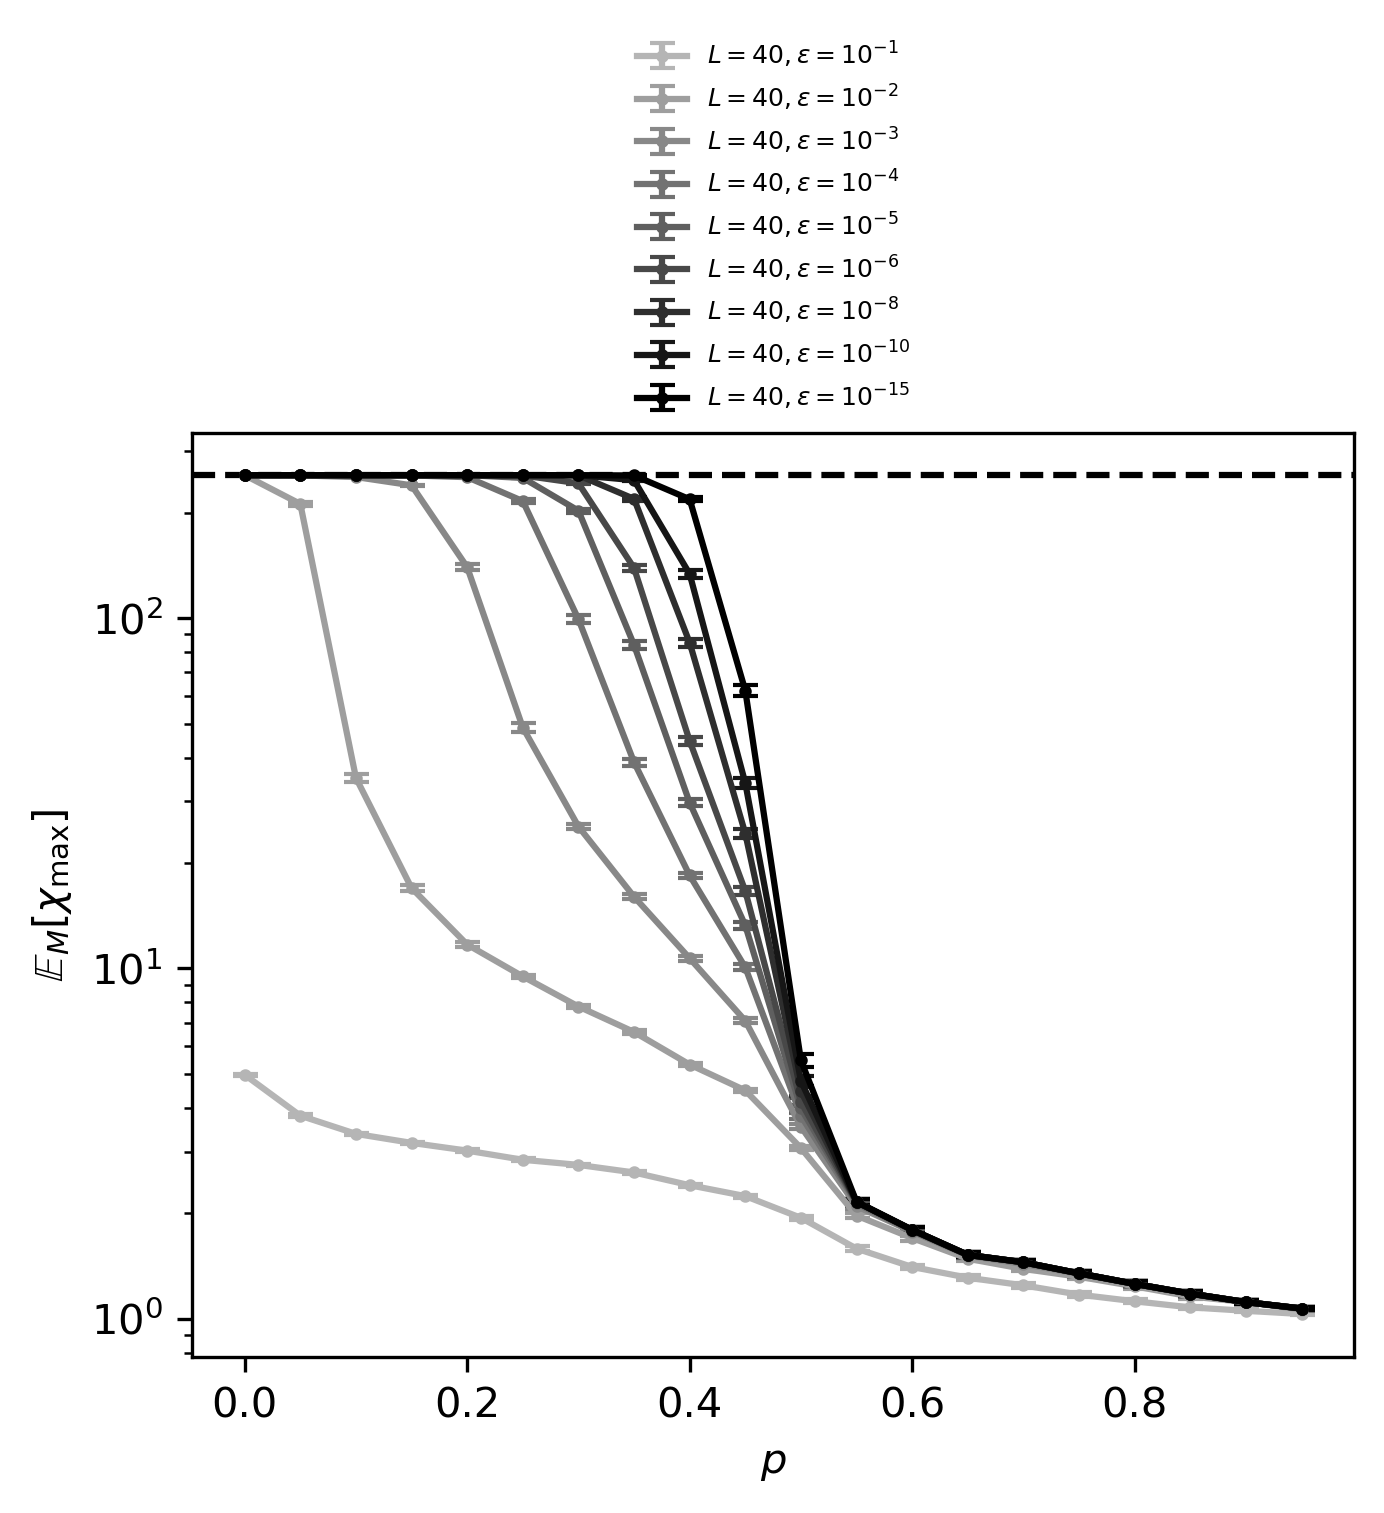

In [126]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
L_list_ = [40]
for idx,L in enumerate(L_list_):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_max_mean_df_ = maxbond_max_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        maxbond_max_sem_df_ = maxbond_max_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = maxbond_max_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,maxbond_max_mean_df_.values.flatten(),yerr=maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$L={L},\epsilon=10^{{ {np.log10(cutoff):.0f}}}$',color = next(cmap),capsize=3,markersize=4)
ax.set_yscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}]$')
ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(L_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

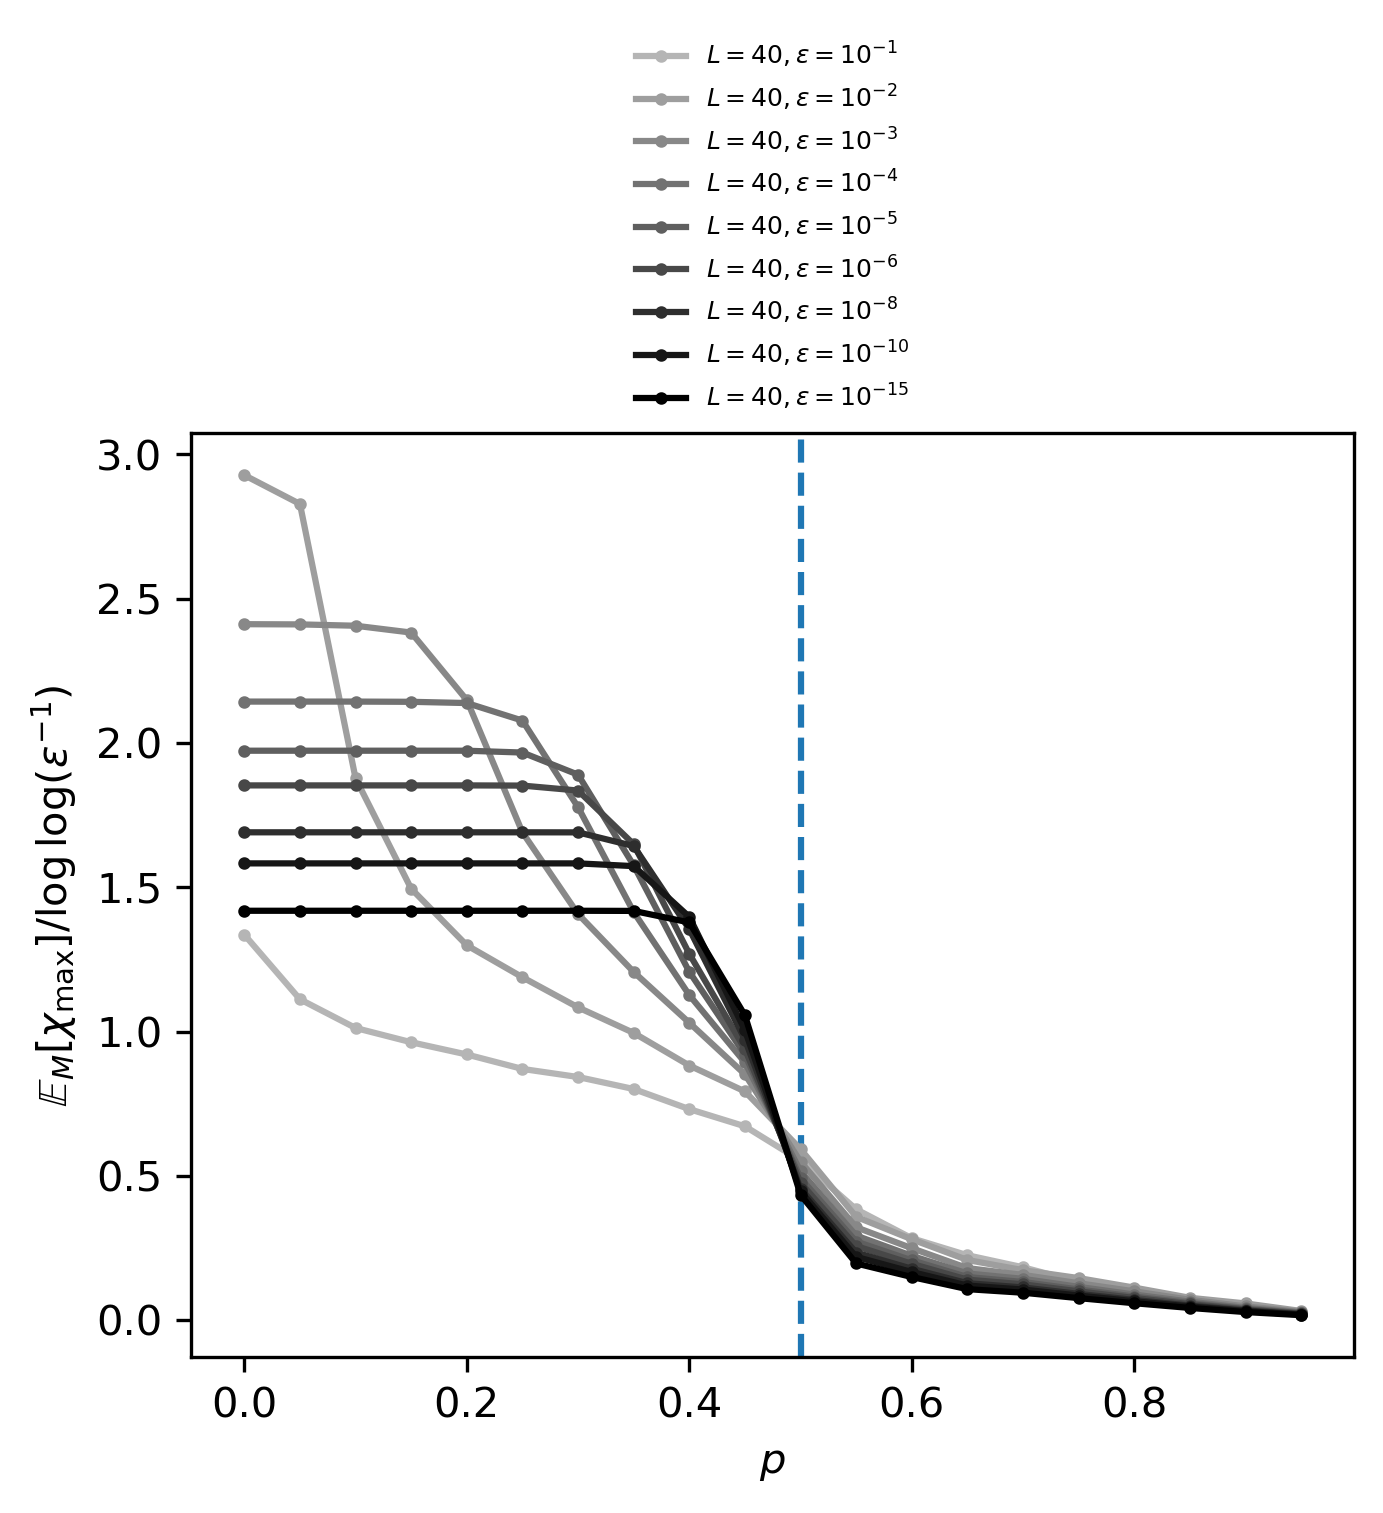

In [152]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
L_list_ = [40]
for idx,L in enumerate(L_list_):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_max_mean_df_ = maxbond_max_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        maxbond_max_sem_df_ = maxbond_max_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = maxbond_max_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,np.log2(maxbond_max_mean_df_.values.flatten())/np.log2(np.log2(1/cutoff)),fmt='.-',label=fr'$L={L},\epsilon=10^{{ {np.log10(cutoff):.0f}}}$',color = next(cmap),capsize=3,markersize=4)
        # ax.errorbar((p_list_-0.3)*(np.log2(1/cutoff)),np.log2(maxbond_max_mean_df_.values.flatten())/np.log2(np.log2(1/cutoff)),fmt='.-',label=fr'$L={L},\epsilon=10^{{ {np.log10(cutoff):.0f}}}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xlabel(r'$p$')
# ax.set_xlim(-10,10)
ax.axvline(0.5,linestyle='--')
# ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}]/\log(\epsilon^{-1})$')
ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}]/\log\log(\epsilon^{-1})$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(L_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

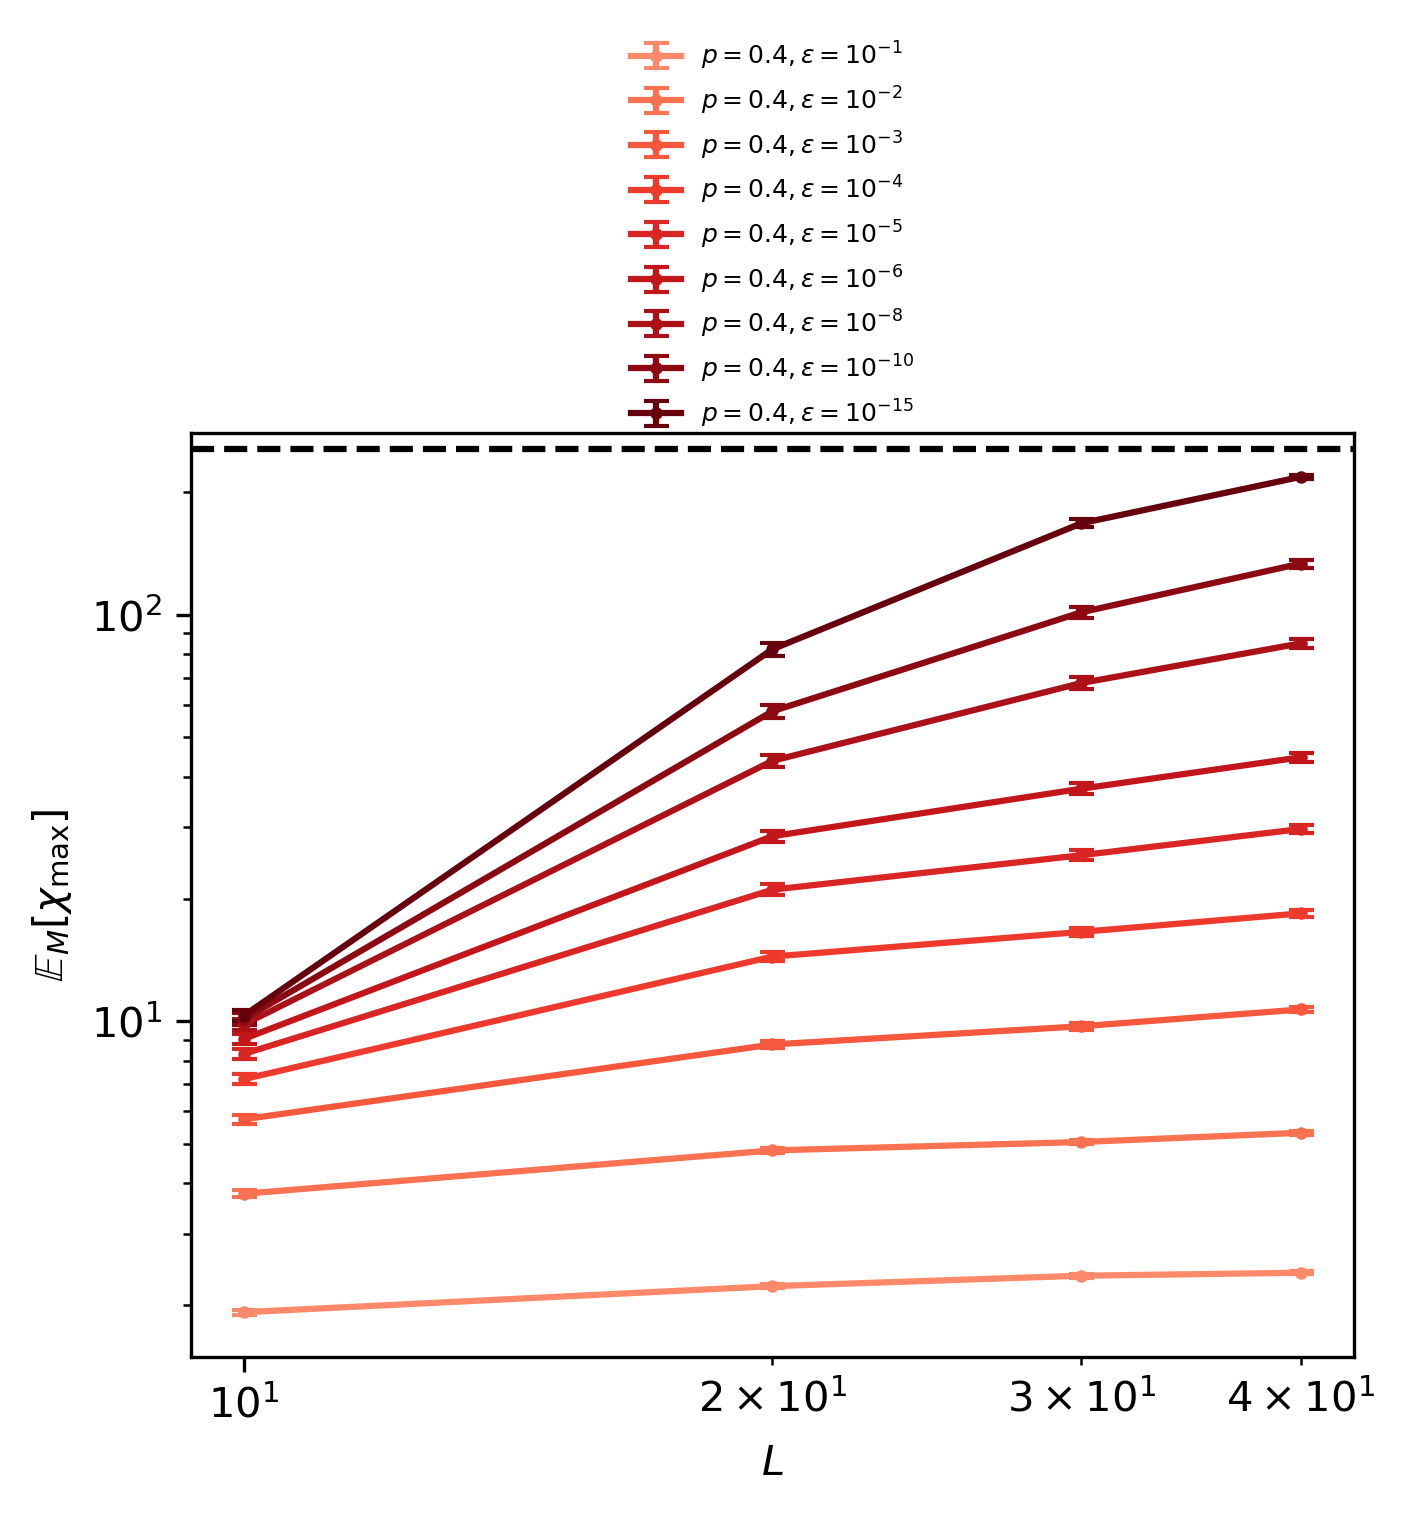

In [64]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
p_list_=[0.4]
for idx,p in enumerate(p_list_):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_max_mean_df_ = maxbond_max_mean_df.xs(p,level='p').xs(cutoff,level='cutoff')
        maxbond_max_sem_df_ = maxbond_max_sem_df.xs(p,level='p').xs(cutoff,level='cutoff')
        L_list_ = maxbond_max_mean_df_.index.get_level_values('L')
        ax.errorbar(L_list_,maxbond_max_mean_df_.values.flatten(),yerr=maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},\epsilon=10^{{ {np.log10(cutoff):.0f}}}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}]$')
ax.axhline(2<<7,linestyle='--',color='black')
# ax.legend(fontsize=5,frameon=False,ncols=3)
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(p_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

In [170]:
1

1

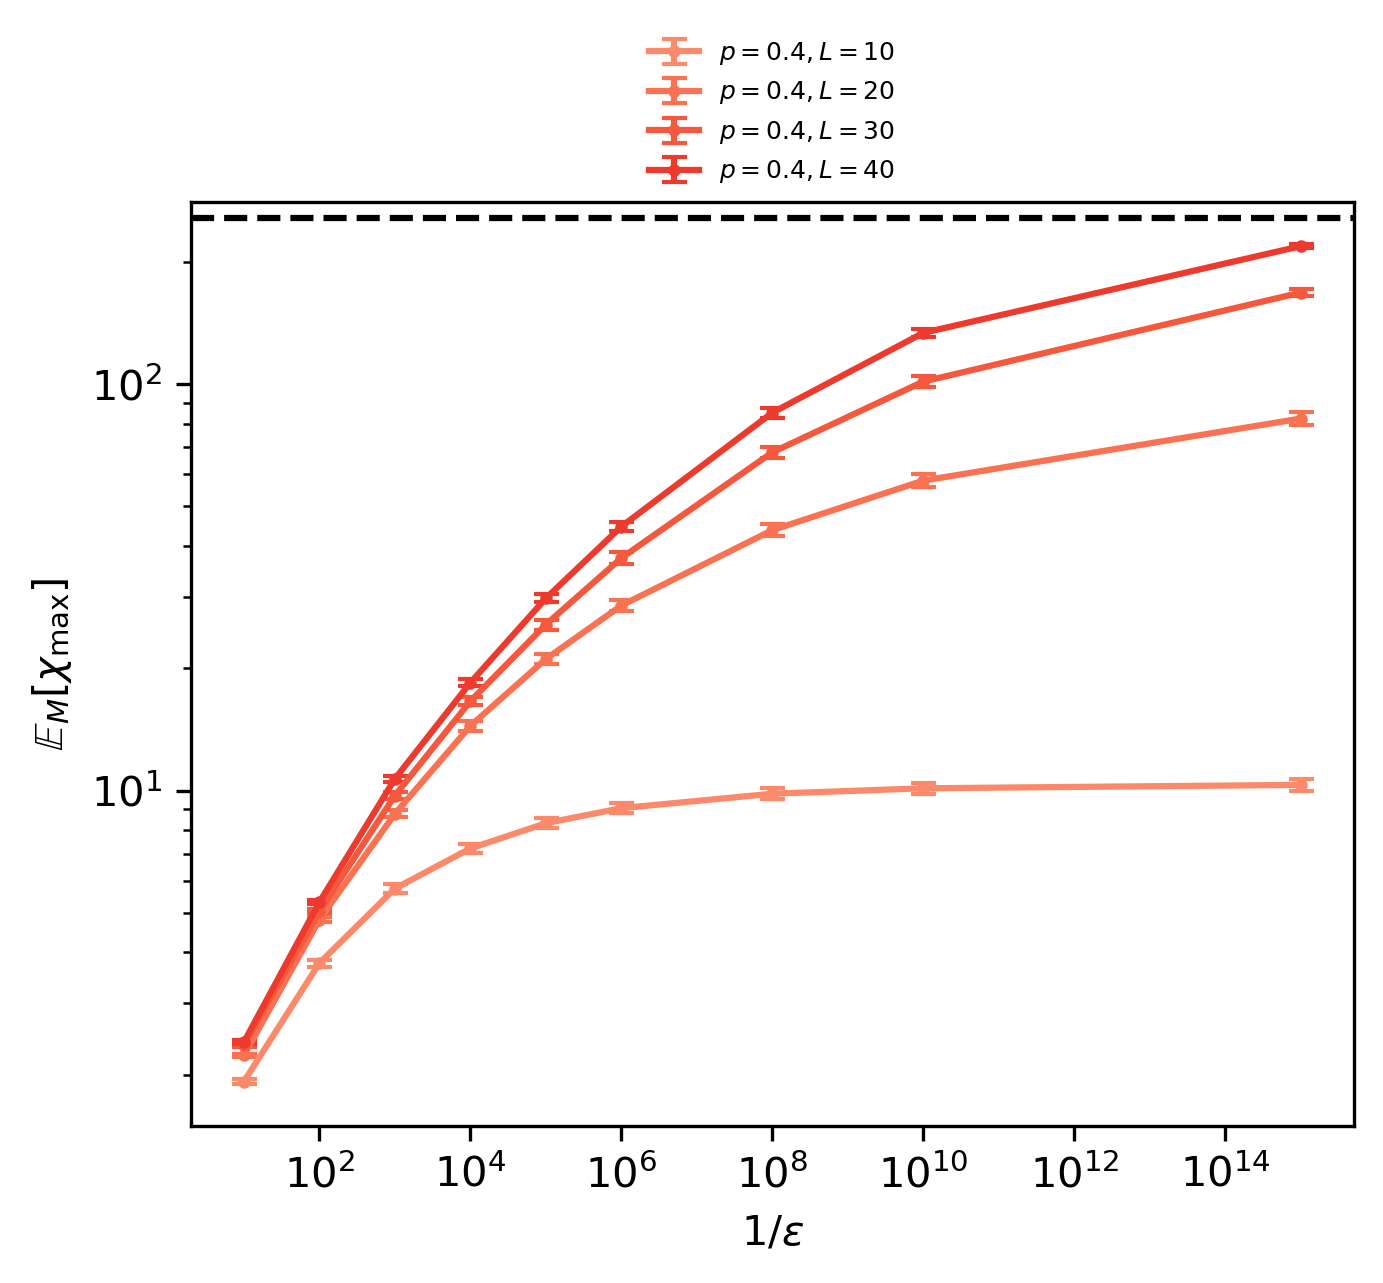

In [82]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
p_list_=[0.4]
for idx,p in enumerate(p_list_):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for L in L_list:
        maxbond_max_mean_df_ = maxbond_max_mean_df.xs(p,level='p').xs(L,level='L')
        maxbond_max_sem_df_ = maxbond_max_sem_df.xs(p,level='p').xs(L,level='L')
        cutoff_list = maxbond_max_mean_df_.index.get_level_values('cutoff')
        ax.errorbar(1/cutoff_list,maxbond_max_mean_df_.values.flatten(),yerr=maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},L={L}$',color = next(cmap),capsize=3,markersize=4)
        # ax.plot(1/cutoff_list, (1-cutoff_list)*2**(L/2) )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/\epsilon$')
ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}]$')
ax.axhline(2<<7,linestyle='--',color='black')
# ax.legend(fontsize=8,frameon=False)
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(p_list_),bbox_to_anchor=(0.5, 1+(len(L_list))*0.05))

## $\langle \log \chi\rangle$ related -- this is closer to Hartley entropy

In [86]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

logmaxbond_max_mean_dict = {}
logmaxbond_max_sem_dict = {}
for idx,L in enumerate([10,20,30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('maxbond',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in cutoff_list:
            # logmaxbond_max_mean_list=[]
            # logmaxbond_max_sem_list=[]
            # p_list_=[]
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                logmaxbond_max_mean = np.log2(np.stack(dataset)[:,:,-1]).max(axis=1).mean(axis=0)
                logmaxbond_max_sem = np.log2(np.stack(dataset)[:,:,-1]).max(axis=1).std(axis=0)/np.sqrt(len(dataset))
                # p_list_.append(p)
                # logmaxbond_max_mean_list.append(logmaxbond_max_mean)
                # logmaxbond_max_sem_list.append(logmaxbond_max_sem)

                logmaxbond_max_mean_dict[(L,cutoff,p)] = logmaxbond_max_mean
                logmaxbond_max_sem_dict[(L,cutoff,p)] = logmaxbond_max_sem

                
            # ax.plot(p_list_,logmaxbond_max_mean_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))

logmaxbond_max_mean_df=convert_pd(logmaxbond_max_mean_dict,names=['L','cutoff','p'])
logmaxbond_max_sem_df=convert_pd(logmaxbond_max_sem_dict,names=['L','cutoff','p'])

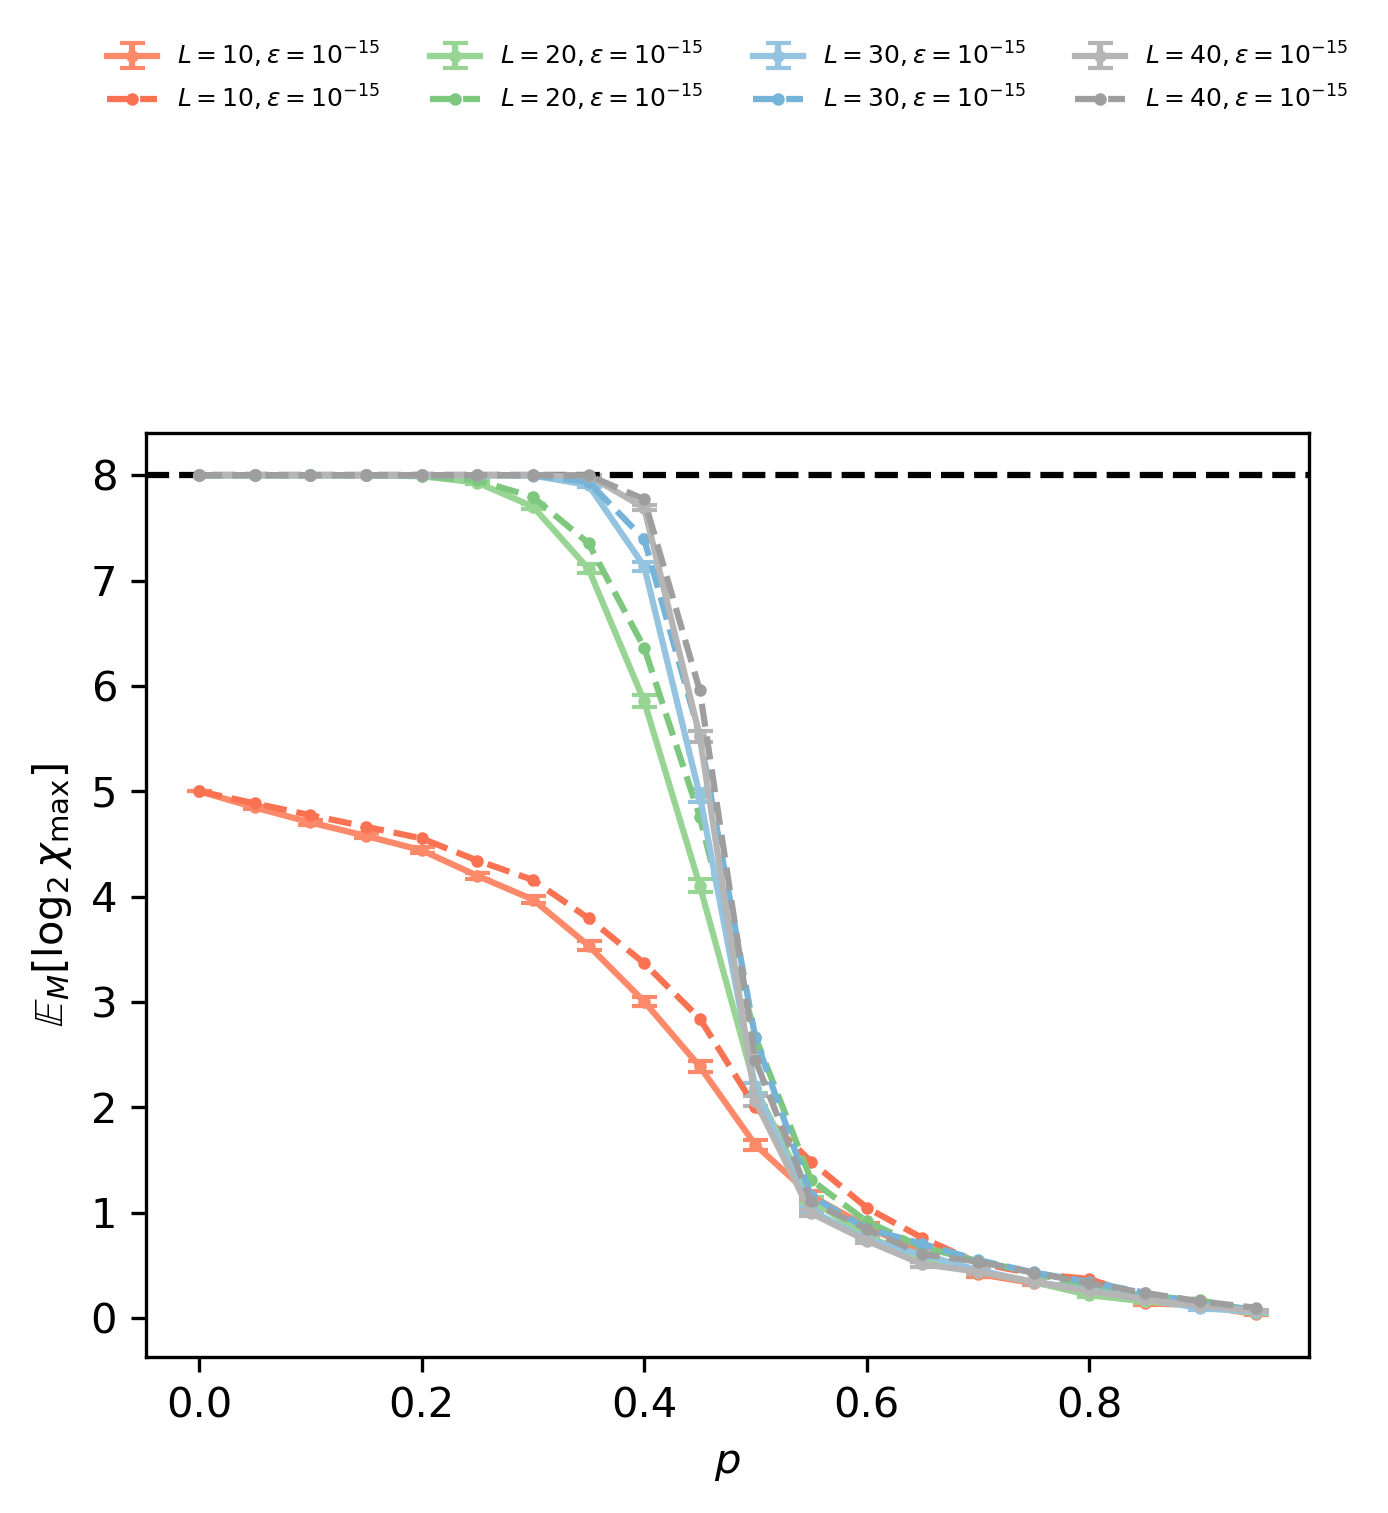

In [108]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
L_list_ = [10,20,30,40]
for idx,L in enumerate(L_list_):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list[-1:]:
        logmaxbond_max_mean_df_ = logmaxbond_max_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        logmaxbond_max_sem_df_ = logmaxbond_max_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = logmaxbond_max_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,logmaxbond_max_mean_df_.values.flatten(),yerr=logmaxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$L={L},\epsilon=10^{{ {np.log10(cutoff):.0f}}}$',color = next(cmap),capsize=3,markersize=4)

        maxbond_max_mean_df_ = maxbond_max_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        maxbond_max_sem_df_ = maxbond_max_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = maxbond_max_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,np.log2(maxbond_max_mean_df_.values.flatten()),fmt='.--',label=fr'$L={L},\epsilon=10^{{ {np.log10(cutoff):.0f}}}$',color = next(cmap),capsize=3,markersize=4)

# ax.set_yscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[\log_2\chi_{\max}]$')
ax.axhline(8,linestyle='--',color='black')
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(L_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

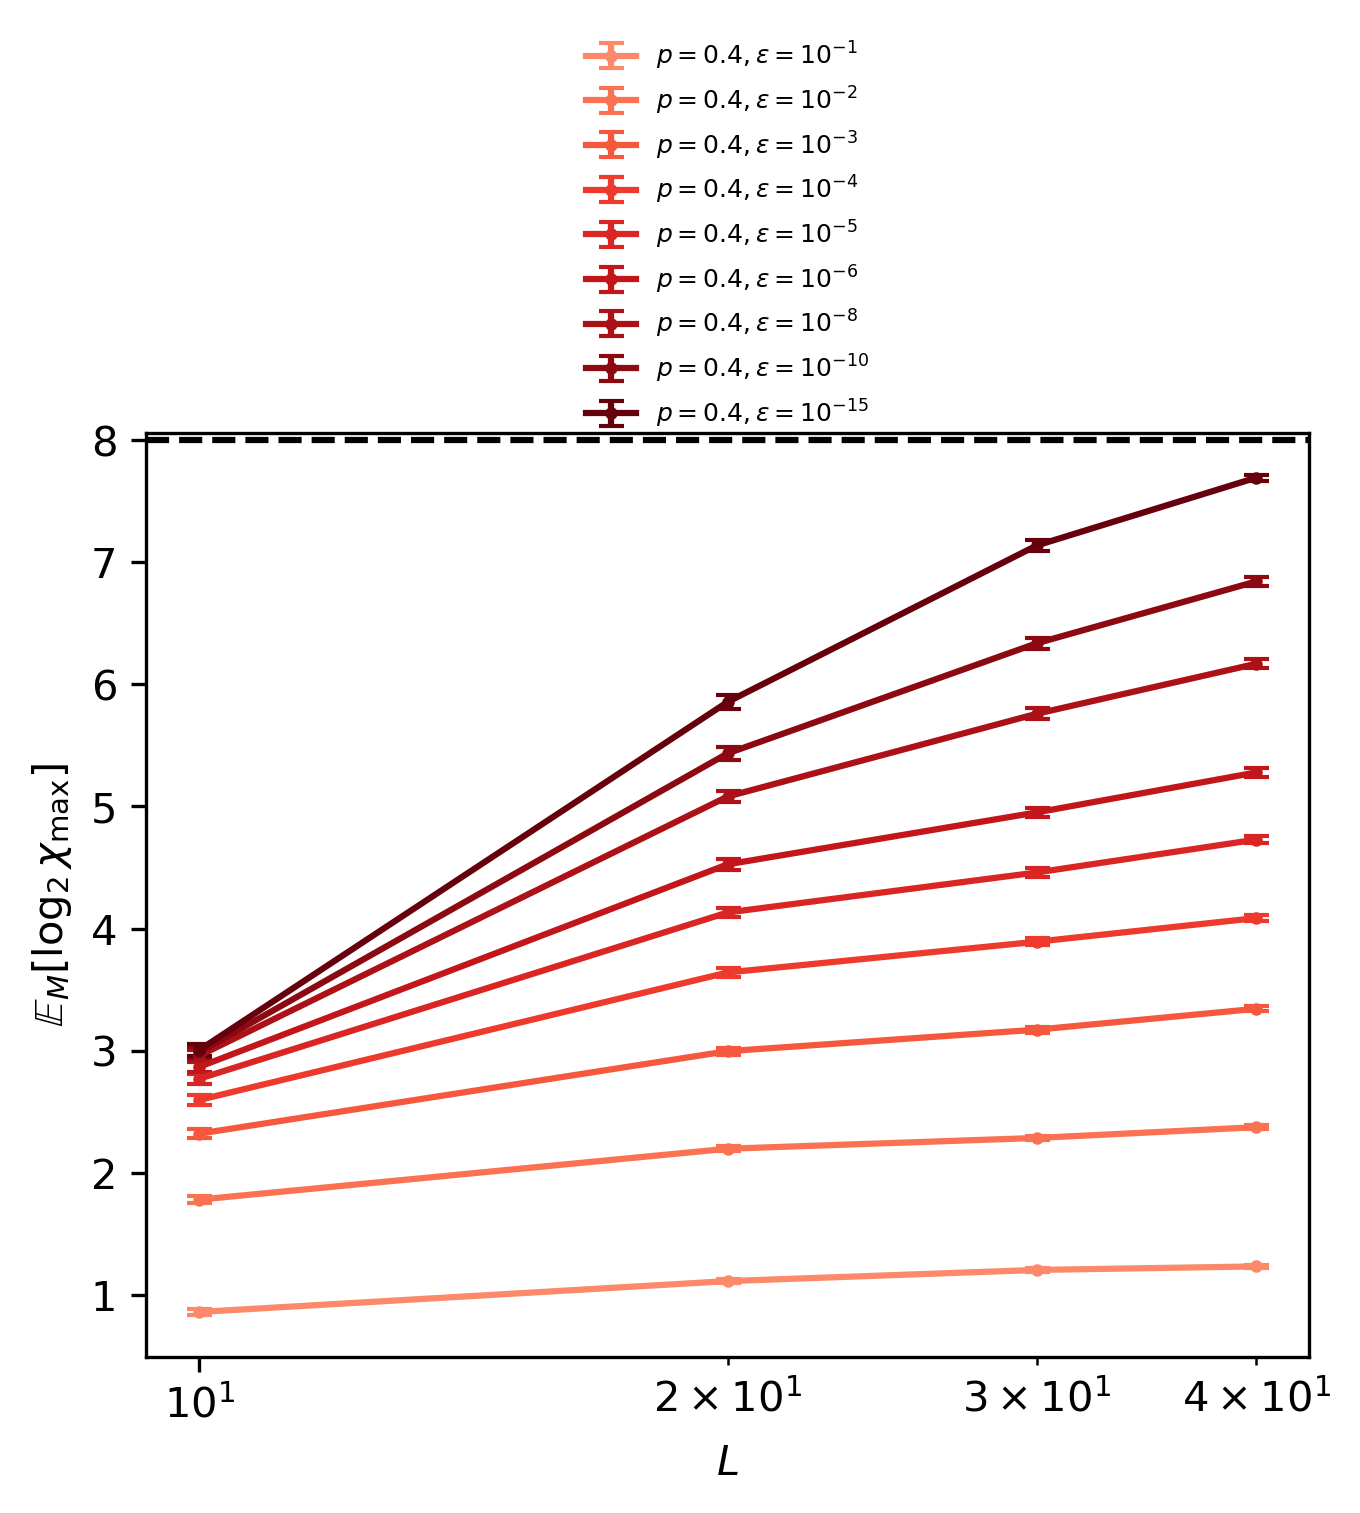

In [113]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
p_list_=[0.4,]
for idx,p in enumerate(p_list_):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        logmaxbond_max_mean_df_ = logmaxbond_max_mean_df.xs(p,level='p').xs(cutoff,level='cutoff')
        logmaxbond_max_sem_df_ = logmaxbond_max_sem_df.xs(p,level='p').xs(cutoff,level='cutoff')
        L_list_ = logmaxbond_max_mean_df_.index.get_level_values('L')
        ax.errorbar(L_list_,logmaxbond_max_mean_df_.values.flatten(),yerr=logmaxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},\epsilon=10^{{ {np.log10(cutoff):.0f}}}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathbb{E}_M[\log_2\chi_{\max}]$')

ax.axhline(8,linestyle='--',color='black')
# ax.legend(fontsize=5,frameon=False,ncols=3)
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(p_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

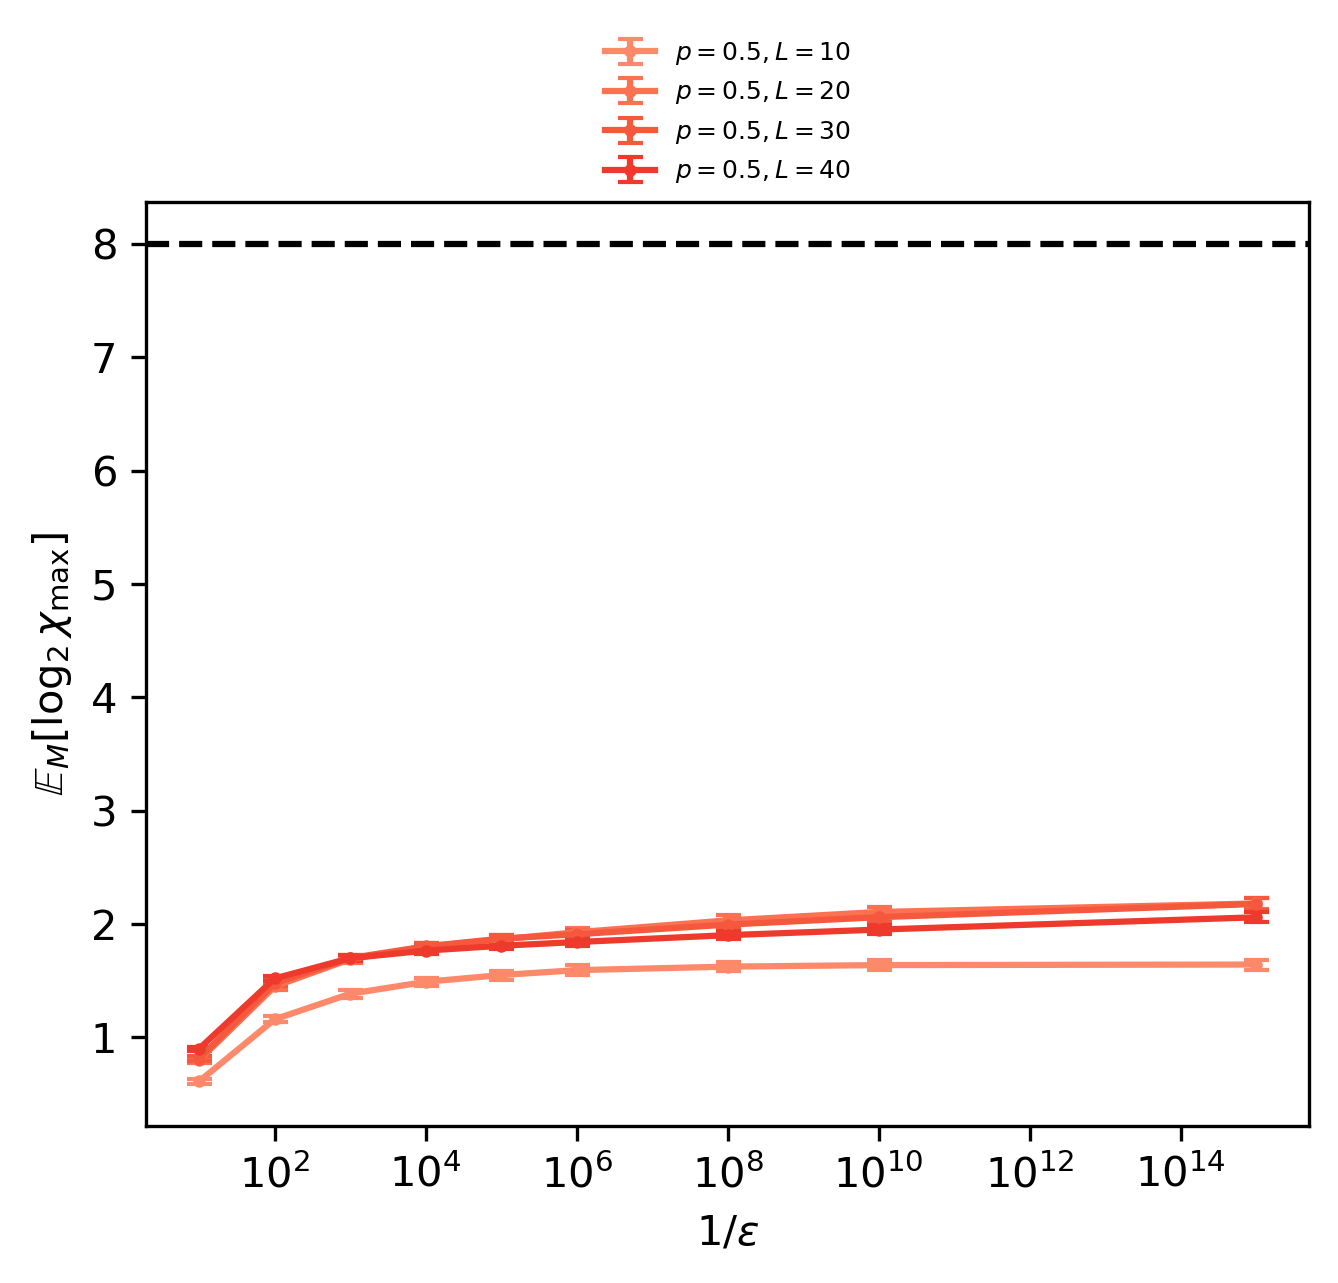

In [124]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
p_list_=[0.5]
for idx,p in enumerate(p_list_):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for L in L_list:
        logmaxbond_max_mean_df_ = logmaxbond_max_mean_df.xs(p,level='p').xs(L,level='L')
        logmaxbond_max_sem_df_ = logmaxbond_max_sem_df.xs(p,level='p').xs(L,level='L')
        cutoff_list = logmaxbond_max_mean_df_.index.get_level_values('cutoff')
        ax.errorbar(1/cutoff_list,logmaxbond_max_mean_df_.values.flatten(),yerr=logmaxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},L={L}$',color = next(cmap),capsize=3,markersize=4)
        # ax.plot(1/cutoff_list, (1-cutoff_list)*2**(L/2) )
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel(r'$1/\epsilon$')
ax.set_ylabel(r'$\mathbb{E}_M[\log_2\chi_{\max}]$')

ax.axhline(8,linestyle='--',color='black')
# ax.legend(fontsize=8,frameon=False)
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(p_list_),bbox_to_anchor=(0.5, 1+(len(L_list))*0.05))

## Time related

In [12]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

t_mean_dict = {}
t_sem_dict = {}
for idx,L in enumerate([10,20,30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('time',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in cutoff_list:
            # t_mean_list=[]
            # t_sem_list=[]
            # p_list_=[]
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                t_mean = np.stack(dataset).mean(axis=0)
                t_sem = np.stack(dataset).std(axis=0)/np.sqrt(len(dataset))
                # p_list_.append(p)
                # t_mean_list.append(t_mean)
                # t_sem_list.append(t_sem)

                t_mean_dict[(L,cutoff,p)] = t_mean
                t_sem_dict[(L,cutoff,p)] = t_sem

                
            # ax.plot(p_list_,t_mean_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))

t_mean_df=convert_pd(t_mean_dict,names=['L','cutoff','p'])
t_sem_df=convert_pd(t_sem_dict,names=['L','cutoff','p'])

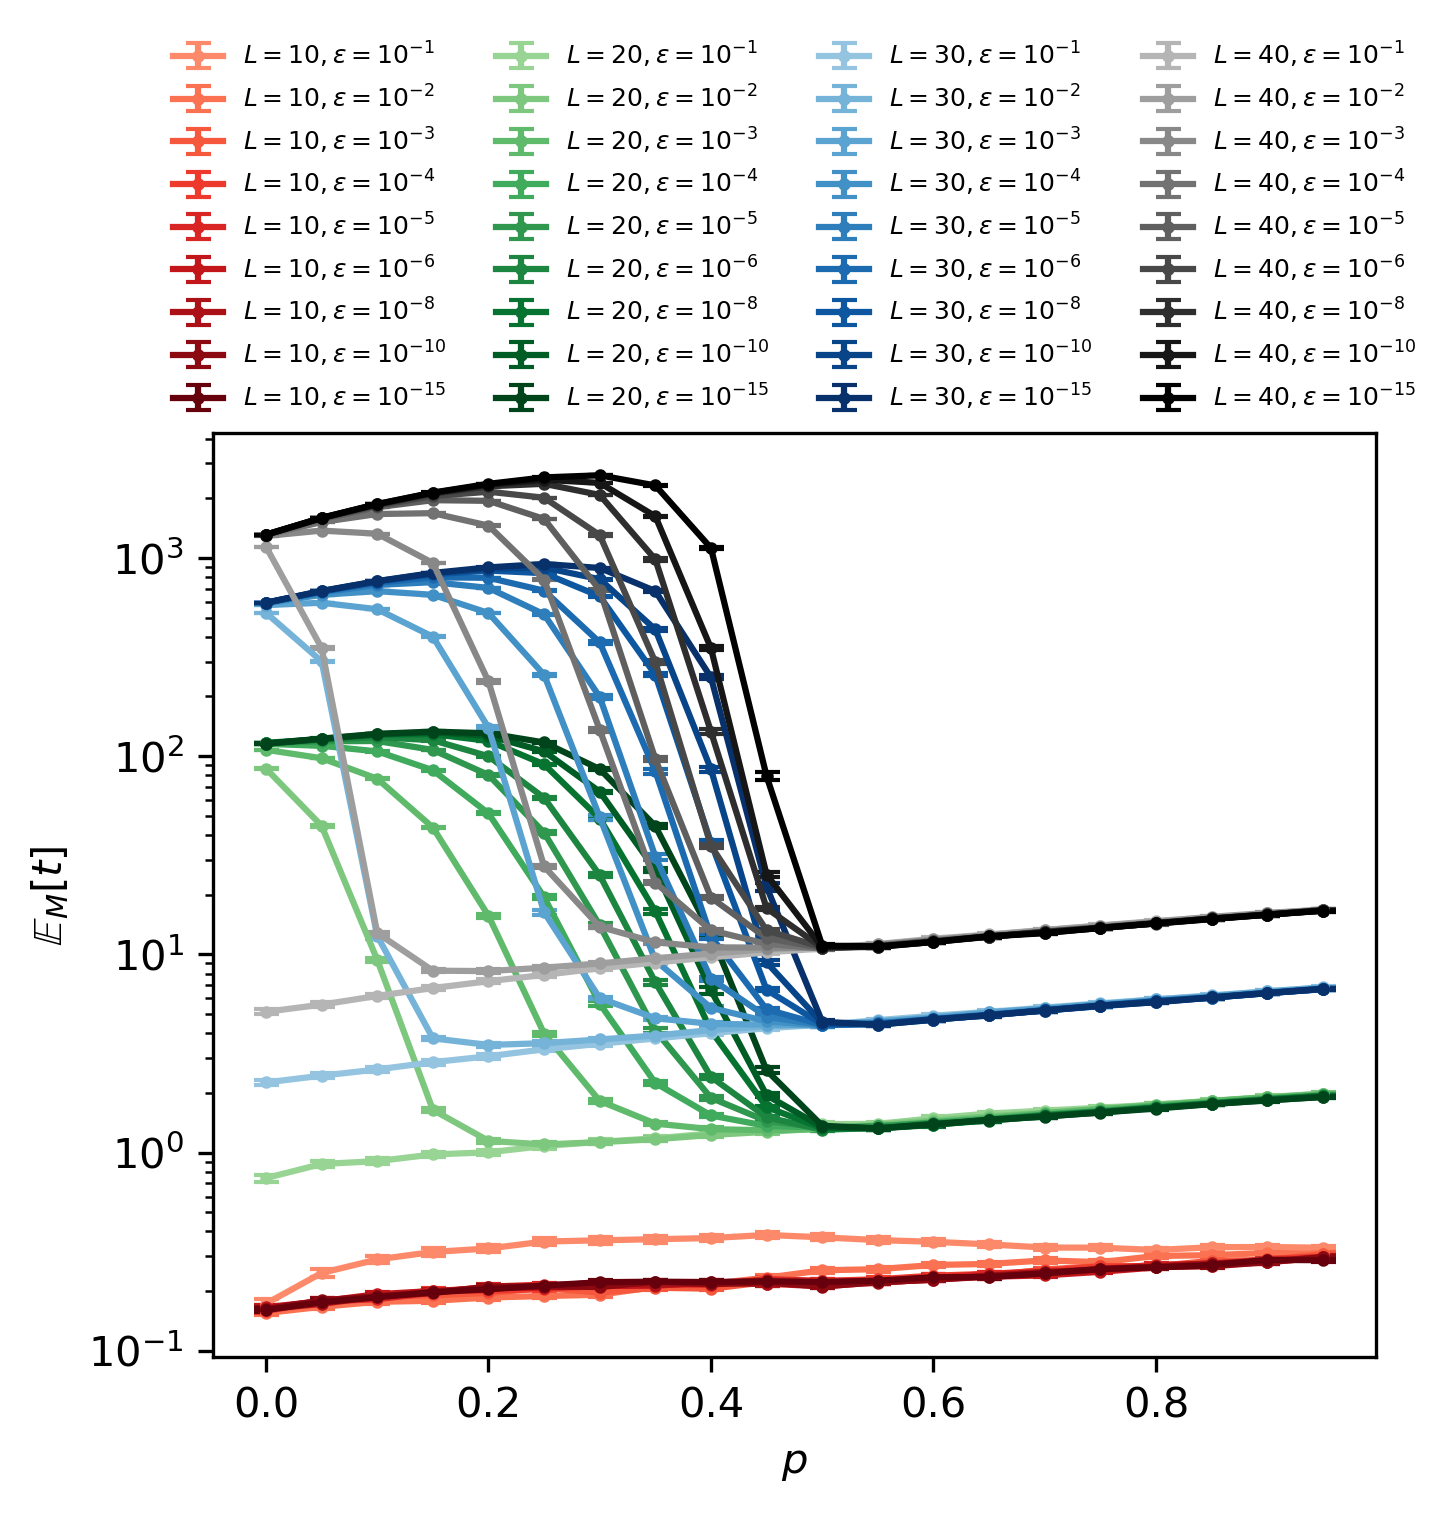

In [398]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,L in enumerate([10,20,30,40]):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        t_mean_df_ = t_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        t_sem_df_ = t_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = t_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,t_mean_df_.values.flatten(),yerr=t_sem_df_.values.flatten(),fmt='.-',label=fr'$L={L},\epsilon=10^{{ {np.log10(cutoff):.0f}}}$',color = next(cmap),capsize=3,markersize=4)
ax.set_yscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[t]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(L_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

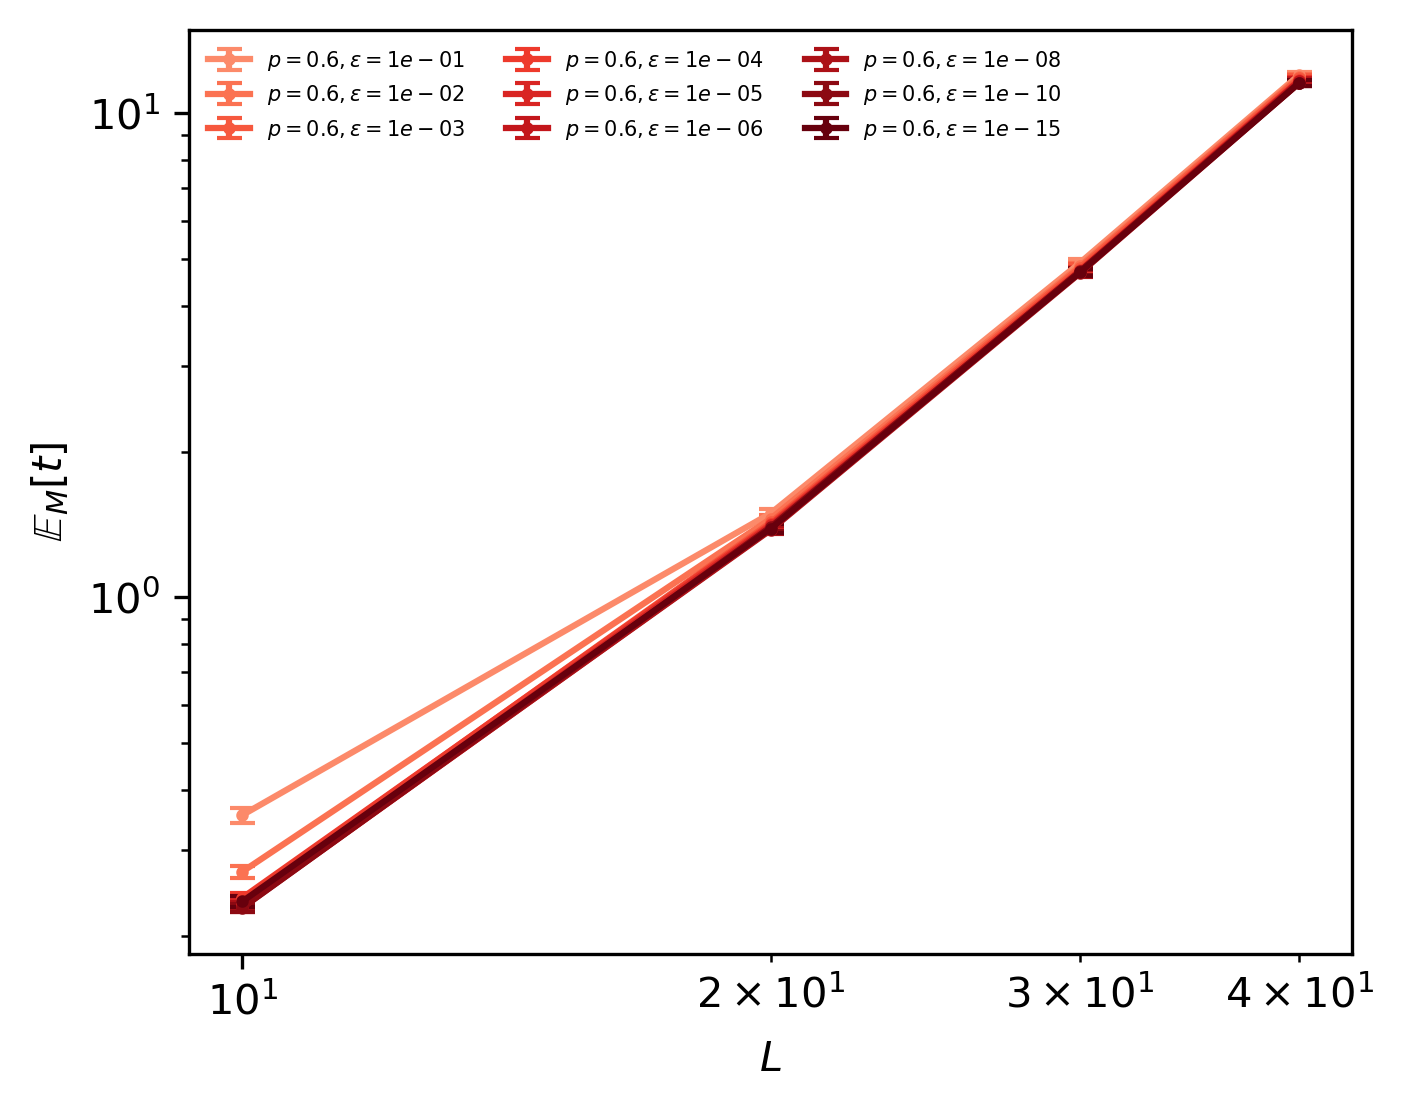

In [95]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.6,]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        t_mean_df_ = t_mean_df.xs(p,level='p').xs(cutoff,level='cutoff')
        t_sem_df_ = t_sem_df.xs(p,level='p').xs(cutoff,level='cutoff')
        L_list_ = t_mean_df_.index.get_level_values('L')
        ax.errorbar(L_list_,t_mean_df_.values.flatten(),yerr=t_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},\epsilon={cutoff:.0e}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathbb{E}_M[t]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=5,frameon=False,ncols=3)

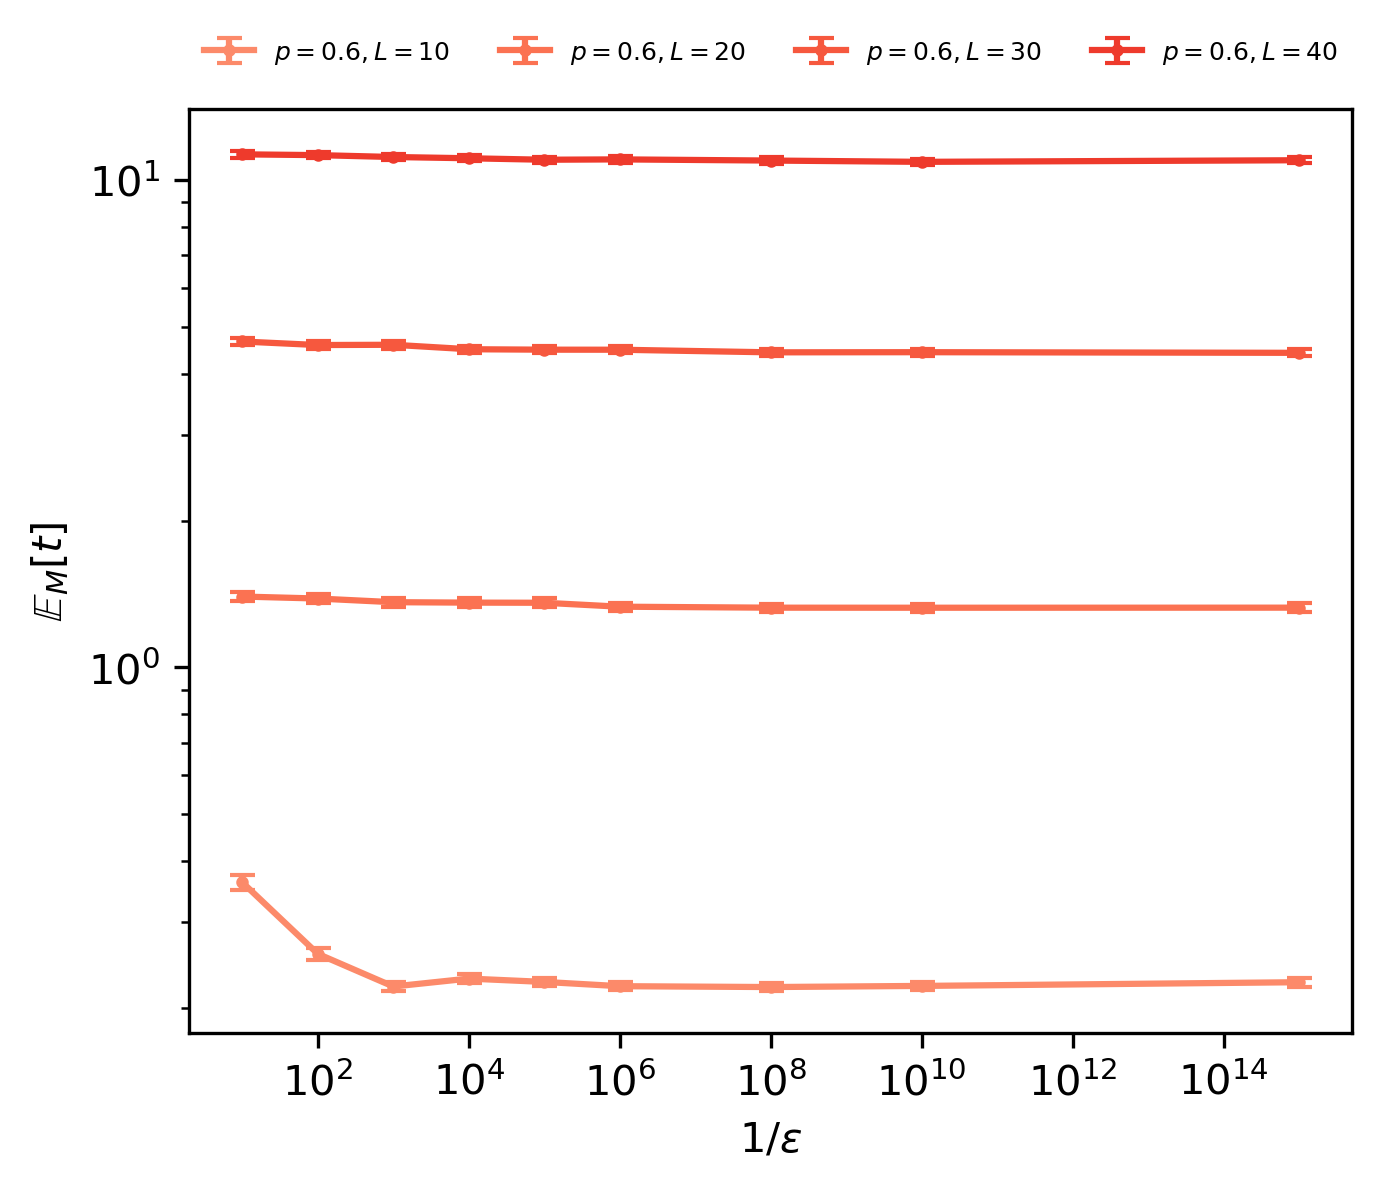

In [88]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.55]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for L in L_list:
        t_mean_df_ = t_mean_df.xs(p,level='p').xs(L,level='L')
        t_sem_df_ = t_sem_df.xs(p,level='p').xs(L,level='L')
        cutoff_list = t_mean_df_.index.get_level_values('cutoff')
        ax.errorbar(1/cutoff_list,t_mean_df_.values.flatten(),yerr=t_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},L={L}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/\epsilon$')
ax.set_ylabel(r'$\mathbb{E}_M[t]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=6,frameon=False,ncols=4,loc='upper center',bbox_to_anchor=(0.5, 1.1))

## temporal maxbond 

In [157]:
from tqdm import tqdm

In [158]:
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

t_maxbond_max_mean_dict = {}
t_maxbond_max_sem_dict = {}
for idx,L in enumerate([10,20,30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('maxbond',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in tqdm(cutoff_list):
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                t_maxbond_max_mean = (np.stack(dataset)).max(axis=1).mean(axis=0)
                t_maxbond_max_sem = (np.stack(dataset)).max(axis=1).std(axis=0)/np.sqrt(len(dataset))

                t_maxbond_max_mean_dict[(L,cutoff,p)] = t_maxbond_max_mean
                t_maxbond_max_sem_dict[(L,cutoff,p)] = t_maxbond_max_sem

                
            # ax.plot(p_list_,t_maxbond_max_mean_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))

t_maxbond_max_mean_df=convert_pd(t_maxbond_max_mean_dict,names=['L','cutoff','p'])
t_maxbond_max_sem_df=convert_pd(t_maxbond_max_sem_dict,names=['L','cutoff','p'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:03<00:00, 13.74s/it]


In [156]:
np.stack(dataset).shape

(500, 39, 3201)

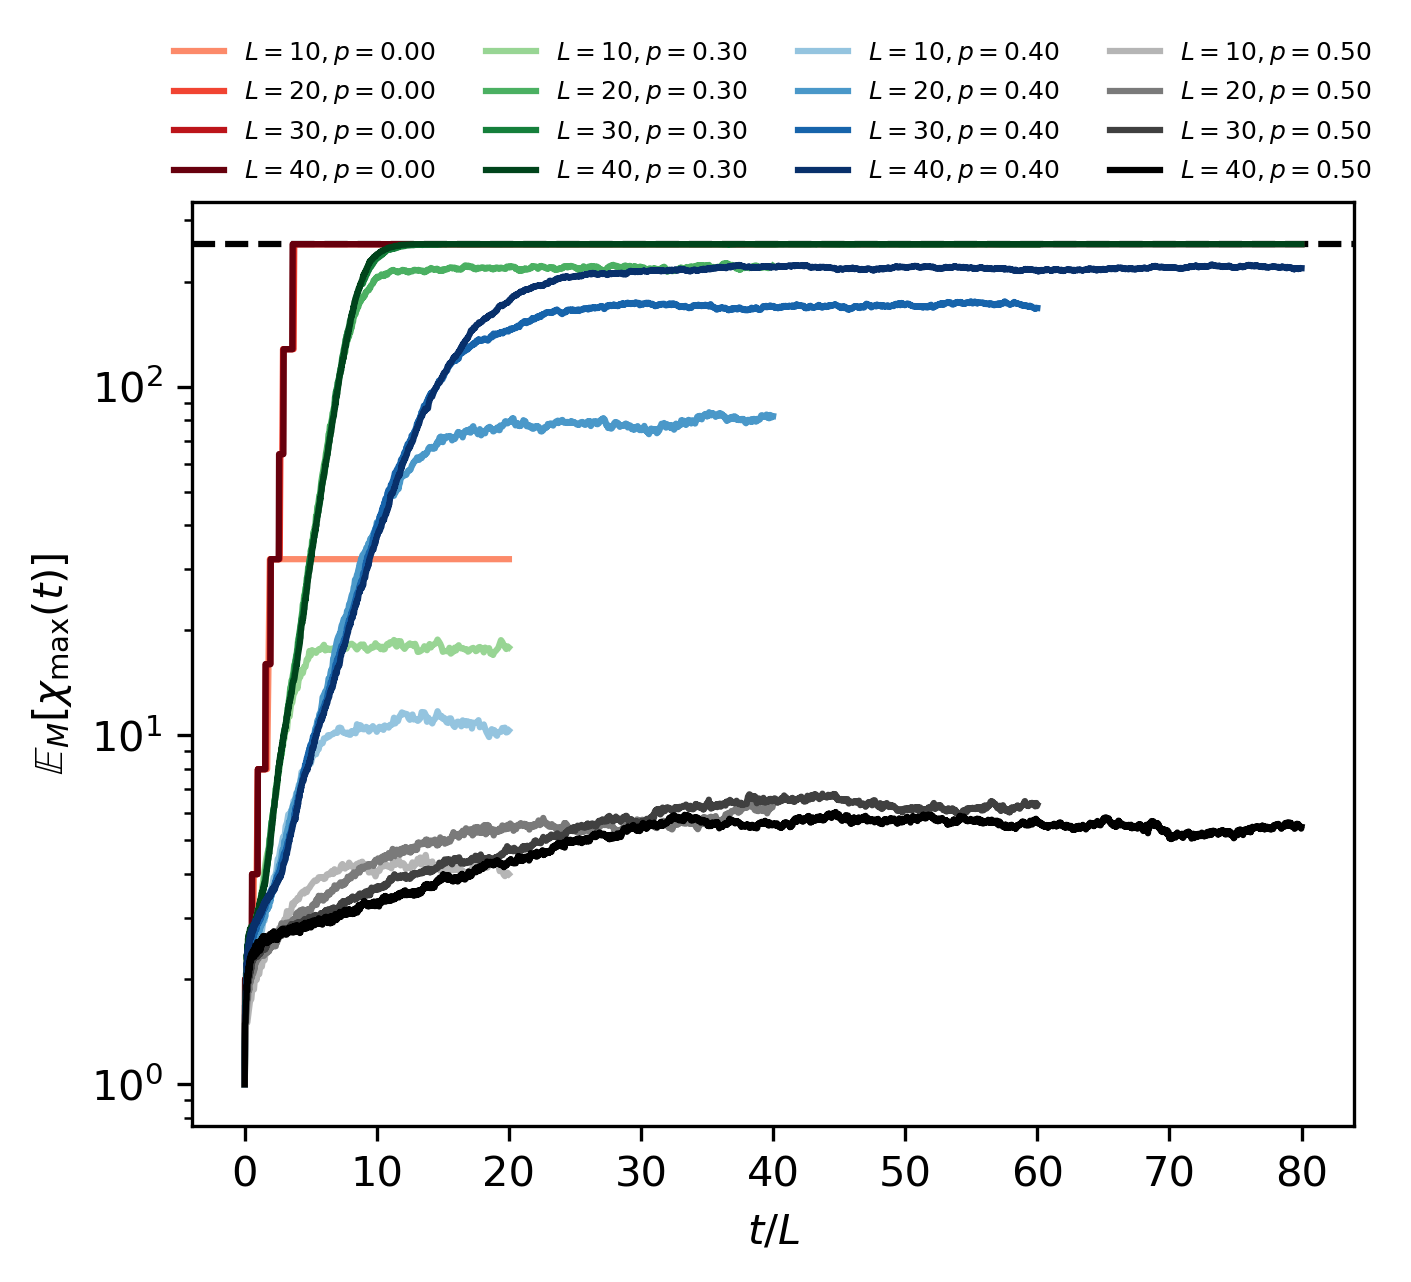

In [191]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
L_list_ = [10,20,30,40]
p_list_ = [0,.3,.4,.5]
for idx,p in enumerate(p_list_):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(L_list_)) ))
    for L in L_list_:
        for cutoff in cutoff_list[-1:]:
            t_maxbond_max_mean_df_ = t_maxbond_max_mean_df['observations'].xs(L,level='L').xs(cutoff,level='cutoff').loc[p]
            # t_maxbond_max_sem_df_ = t_maxbond_max_sem_df['observations'].xs(L,level='L').xs(cutoff,level='cutoff').loc[p]
            # t_list_ = t_maxbond_max_mean_df_.index.get_level_values('p')
            ax.errorbar(np.arange(t_maxbond_max_mean_df_.shape[0])/L,t_maxbond_max_mean_df_,yerr=None,fmt='-',label=fr'$L={L},p={p:.2f}$',color = next(cmap),capsize=3,markersize=4)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel(r'$t/L$')
ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}(t)]$')
ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(p_list_),bbox_to_anchor=(0.5, 1+(len(p_list_))*0.05))

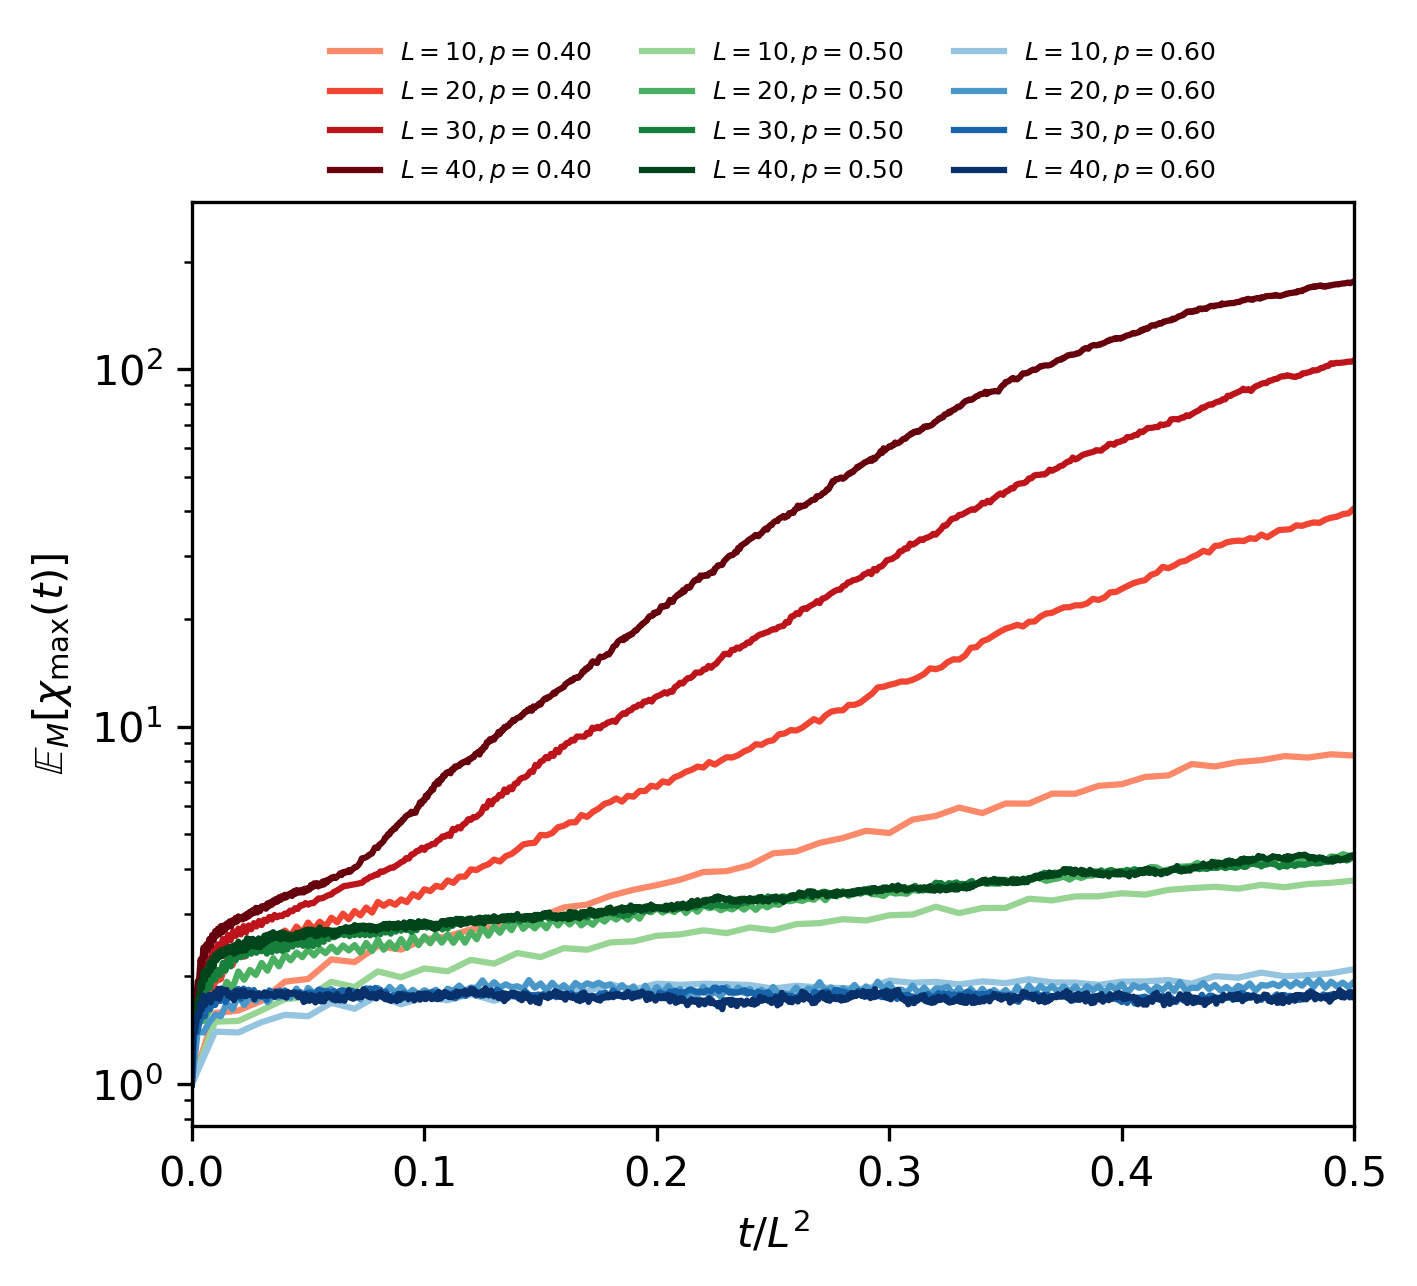

In [307]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
L_list_ = [10,20,30,40]
p_list_ = [.4,.5,.6]
for idx,p in enumerate(p_list_):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(L_list_)) ))
    for L in L_list_:
        for cutoff in cutoff_list[-1:]:
            t_maxbond_max_mean_df_ = t_maxbond_max_mean_df['observations'].xs(L,level='L').xs(cutoff,level='cutoff').loc[p]
            # t_maxbond_max_sem_df_ = t_maxbond_max_sem_df['observations'].xs(L,level='L').xs(cutoff,level='cutoff').loc[p]
            # t_list_ = t_maxbond_max_mean_df_.index.get_level_values('p')
            ax.errorbar(np.arange(t_maxbond_max_mean_df_.shape[0])/L**2,t_maxbond_max_mean_df_,yerr=None,fmt='-',label=fr'$L={L},p={p:.2f}$',color = next(cmap),capsize=3,markersize=4)
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0,.5)
ax.set_xlabel(r'$t/L^2$')
ax.set_ylabel(r'$\mathbb{E}_M[\chi_{\max}(t)]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(p_list_),bbox_to_anchor=(0.5, 1+(len(L_list_))*0.05))

## Dynamics maxbond

In [217]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

log_maxbond_mean_dict = {}
log_maxbond_sem_dict = {}
for idx,L in enumerate([30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('maxbond',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in tqdm(cutoff_list):
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                log_maxbond_mean = np.log2(np.stack(dataset)).mean(axis=0)
                log_maxbond_sem = np.log2(np.stack(dataset)).std(axis=0)/np.sqrt(len(dataset))

                log_maxbond_mean_dict[(L,cutoff,p)] = log_maxbond_mean
                log_maxbond_sem_dict[(L,cutoff,p)] = log_maxbond_sem

                

log_maxbond_mean_df=convert_pd(log_maxbond_mean_dict,names=['L','cutoff','p'])
log_maxbond_sem_df=convert_pd(log_maxbond_sem_dict,names=['L','cutoff','p'])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [08:08<00:00, 54.27s/it]


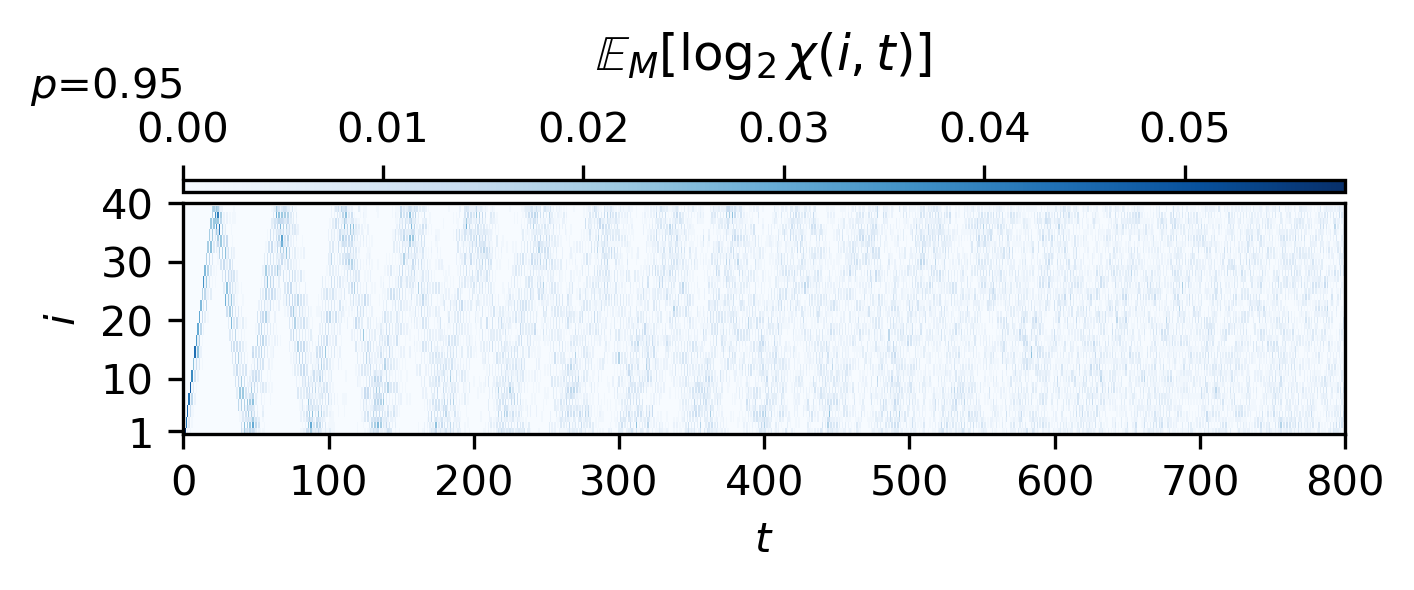

In [281]:
fig,ax=plt.subplots(1,1,figsize=(5,1))
L=40
ε=1e-15
p=.95
im = ax.pcolormesh(np.arange(2*L**2+1),np.arange(1,L),log_maxbond_mean_dict[(L,ε,p)],cmap='Blues')

axins = ax.inset_axes([0, 1.05, 1, 0.05]) 
cb = plt.colorbar(im, cax=axins, orientation='horizontal')
axins.xaxis.set_ticks_position('top')
axins.xaxis.set_label_position('top')
axins.set_title(r'$\mathbb{E}_M[\log_2 \chi(i,t)]$', pad=10)
ax.text(0,1.6,f'$p$={p:.2f}',transform = ax.transAxes,ha='right',va='top')

ax.set_xlabel('$t$')
ax.set_ylabel('$i$')
ax.set_xlim(None,L**2/2)
ax.set_yticks([1]+list(range(10,L+1,10)))

In [288]:
np.stack(log_maxbond_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')['observations']).max(axis=1).sum(axis=-1)

array([25036.        , 24960.14734246, 24873.3385891 , 24759.62297712,
       24621.29619598, 24420.32285892, 24124.73677323, 23469.08558859,
       20649.69249487, 13115.78837746,  3949.80228864,   893.56252933,
         470.7       ,   308.674     ,   223.332     ,   167.046     ,
         126.18      ,    92.124     ,    62.866     ,    36.398     ])

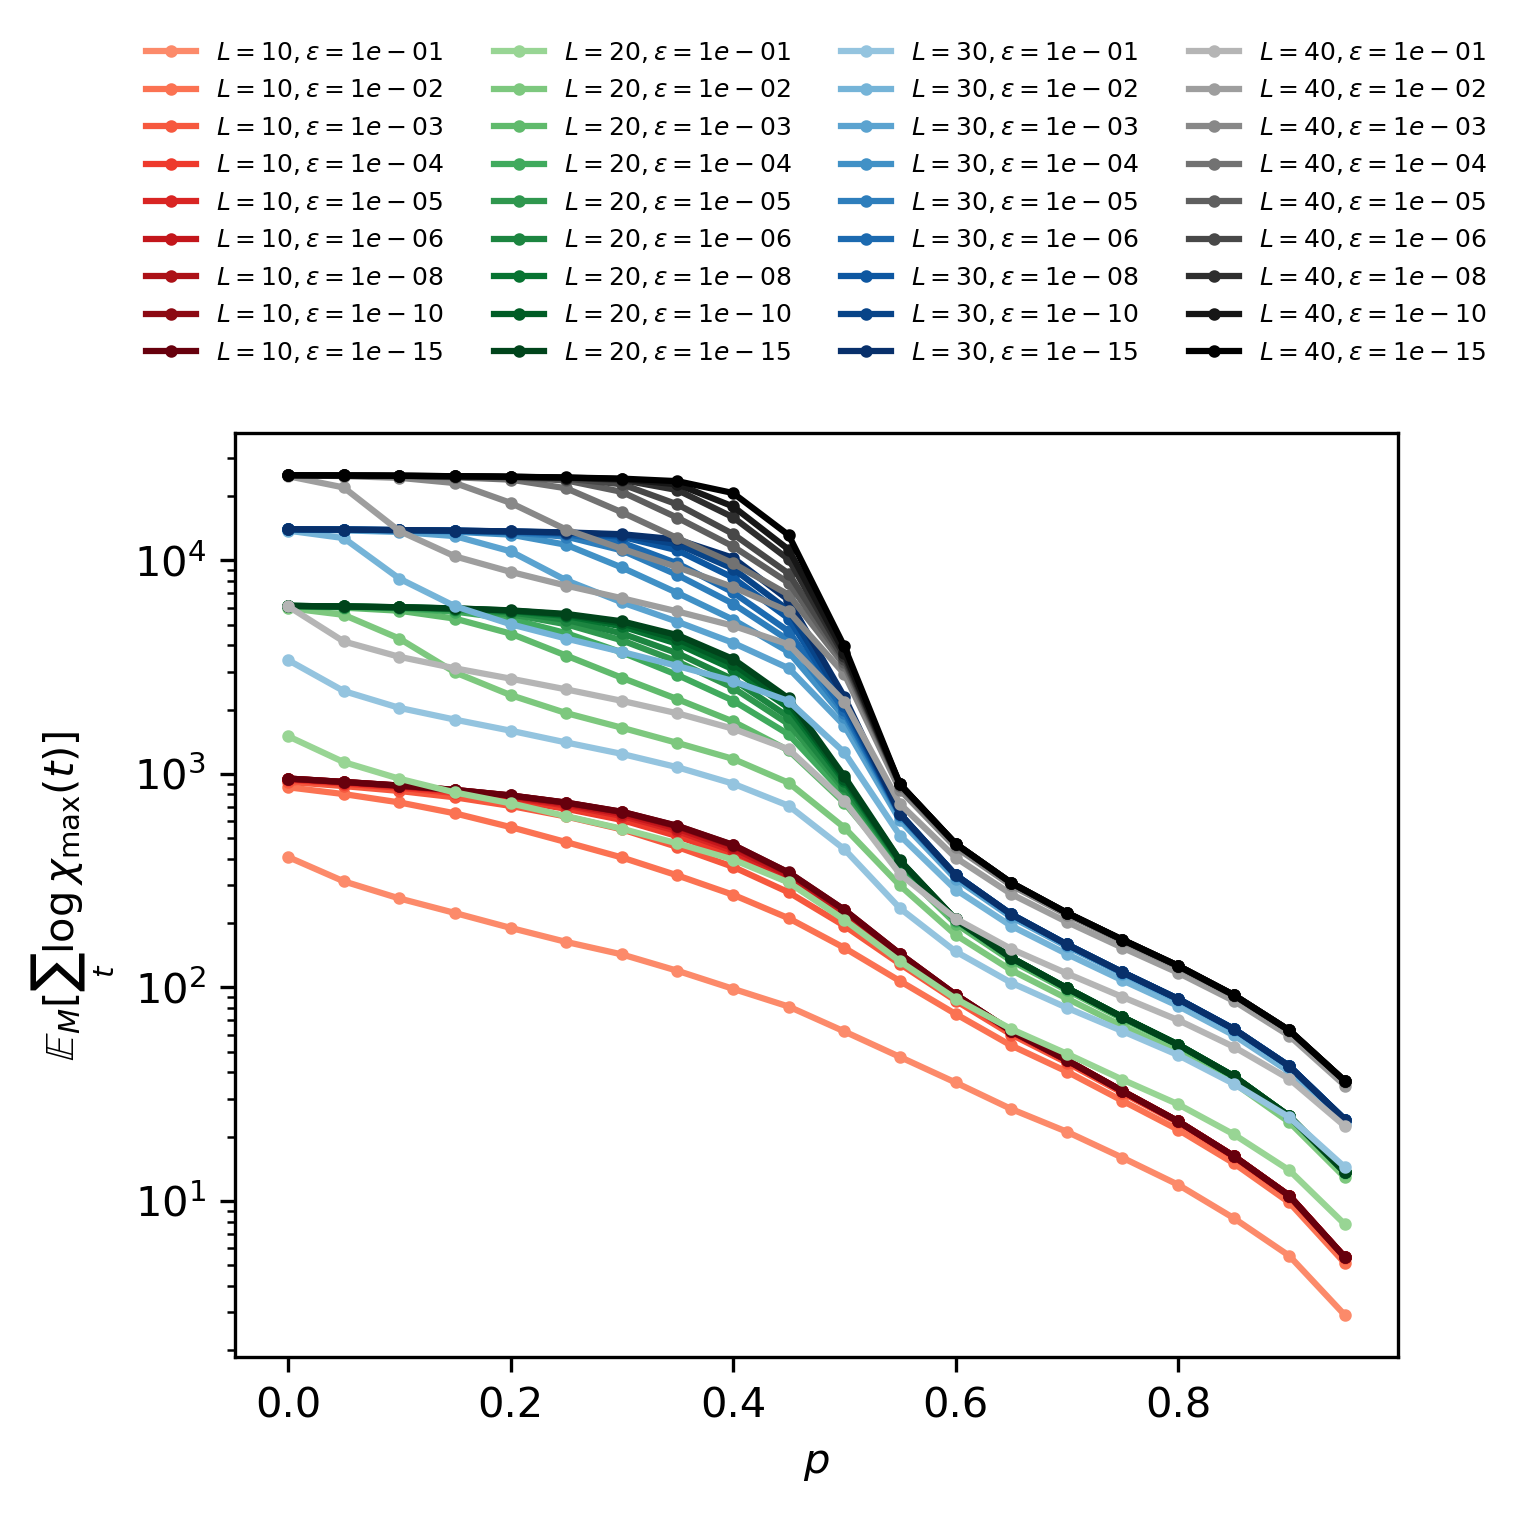

In [299]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,L in enumerate([10,20,30,40,]):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        color_ = next(cmap)
        data_ = log_maxbond_mean_df['observations'].xs(L,level='L').xs(cutoff,level='cutoff')
        log_maxbond_mean_df_ = np.stack(data_).max(axis=1).sum(axis=-1)
        # log_maxbond_sem_df_ = log_maxbond_sem_df['observations'].xs(L,level='L').xs(cutoff,level='cutoff').max(axis=1).sum(axis=-1)
        p_list_ = data_.index.get_level_values('p')
        ax.errorbar(p_list_,log_maxbond_mean_df_,fmt='.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = color_,capsize=3,markersize=4)
        # ax.axhline(2**4*L**2,linestyle='--',color=color_)

ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[\sum_t\log\chi_{\max}(t)]$')
# ax.legend(fontsize=5,loc='upper center',frameon=False,ncols=4,bbox_to_anchor=(.5, 1.33))
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(L_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

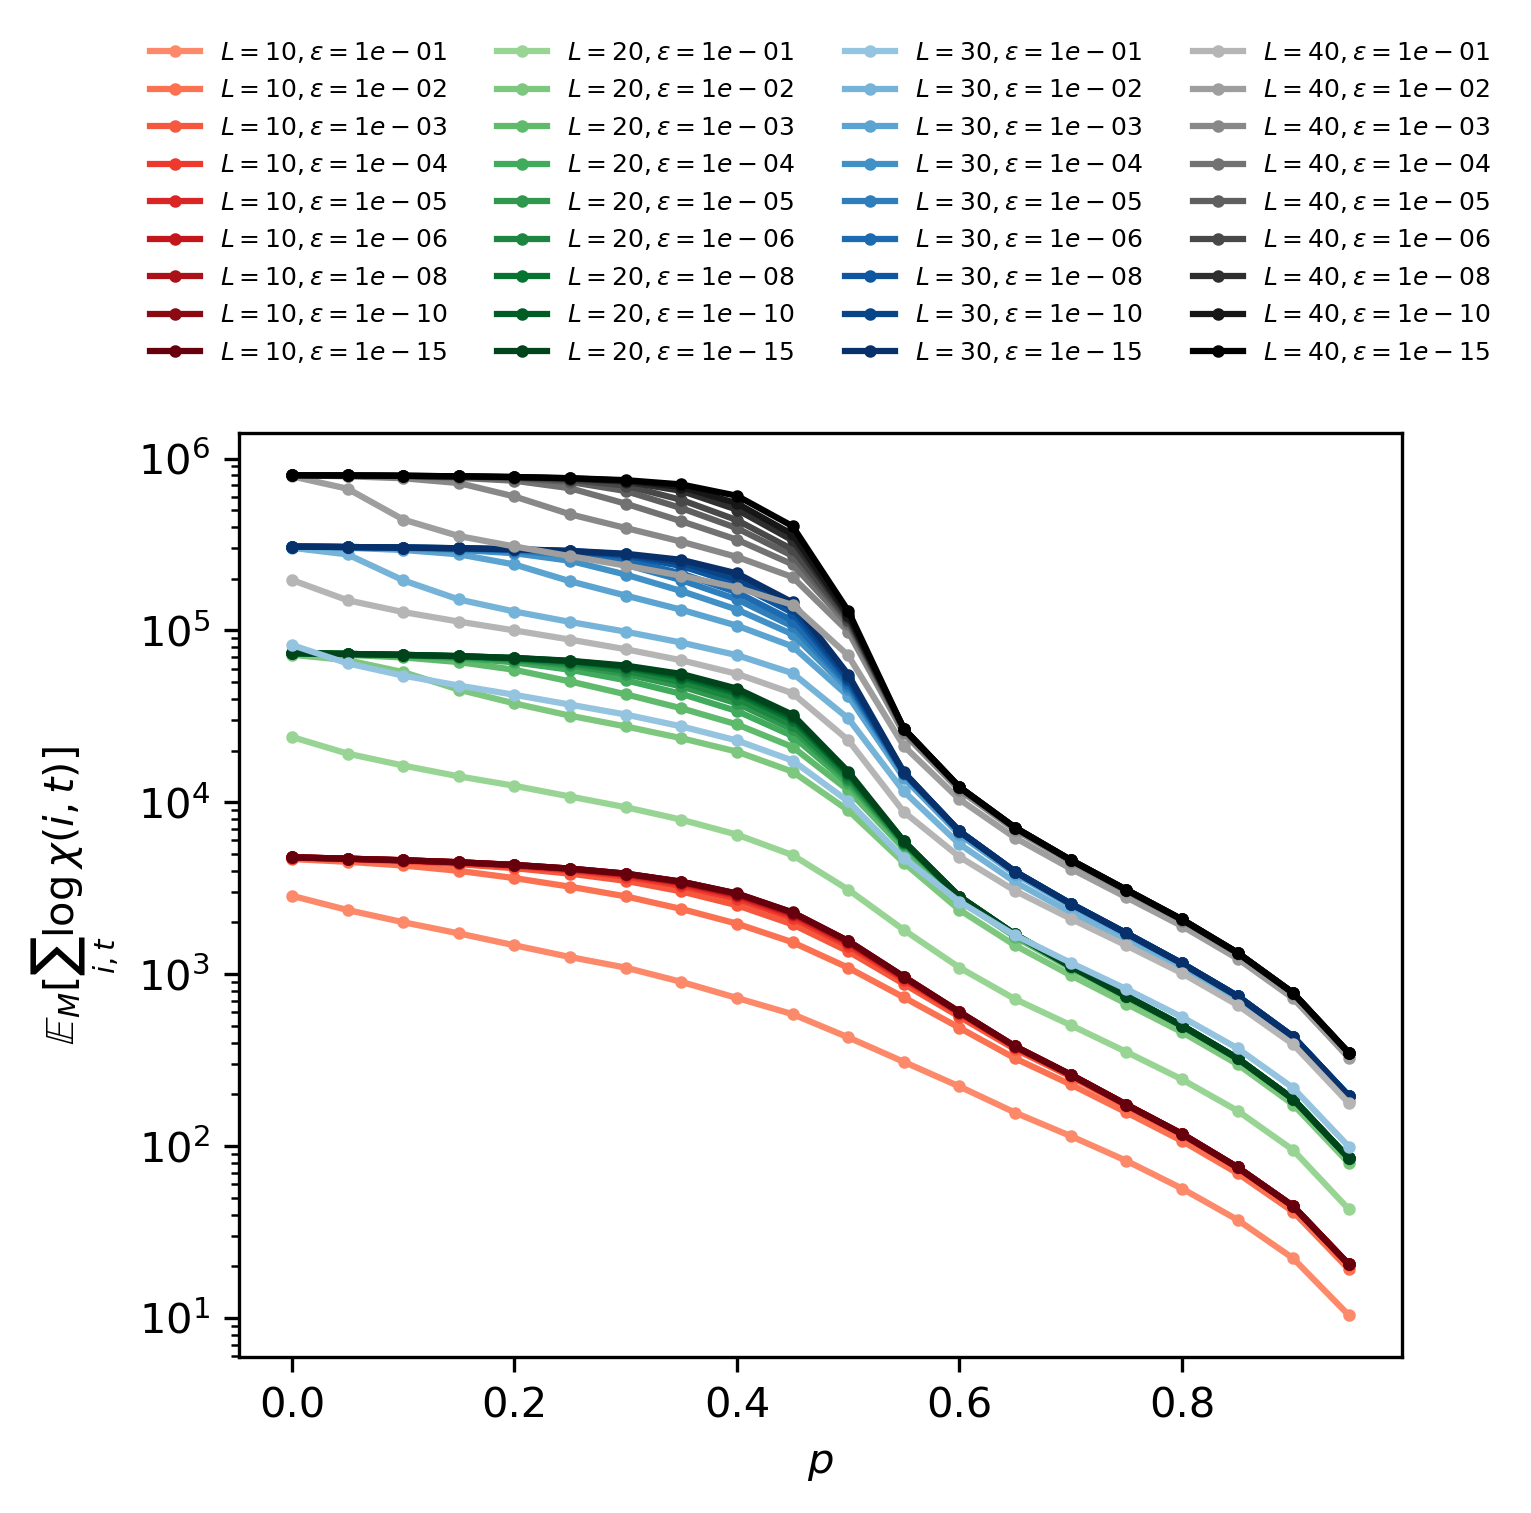

In [294]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,L in enumerate([10,20,30,40,]):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        color_ = next(cmap)
        data_ = log_maxbond_mean_df['observations'].xs(L,level='L').xs(cutoff,level='cutoff')
        log_maxbond_mean_df_ = np.stack(data_).sum(axis=(1,2))
        # log_maxbond_sem_df_ = log_maxbond_sem_df['observations'].xs(L,level='L').xs(cutoff,level='cutoff').max(axis=1).sum(axis=-1)
        p_list_ = data_.index.get_level_values('p')
        ax.errorbar(p_list_,log_maxbond_mean_df_,fmt='.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = color_,capsize=3,markersize=4)
        # ax.axhline(2**4*L**2,linestyle='--',color=color_)

ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[\sum_{i,t}\log\chi(i,t)]$')
# ax.legend(fontsize=5,loc='upper center',frameon=False,ncols=4,bbox_to_anchor=(.5, 1.33))
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(L_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

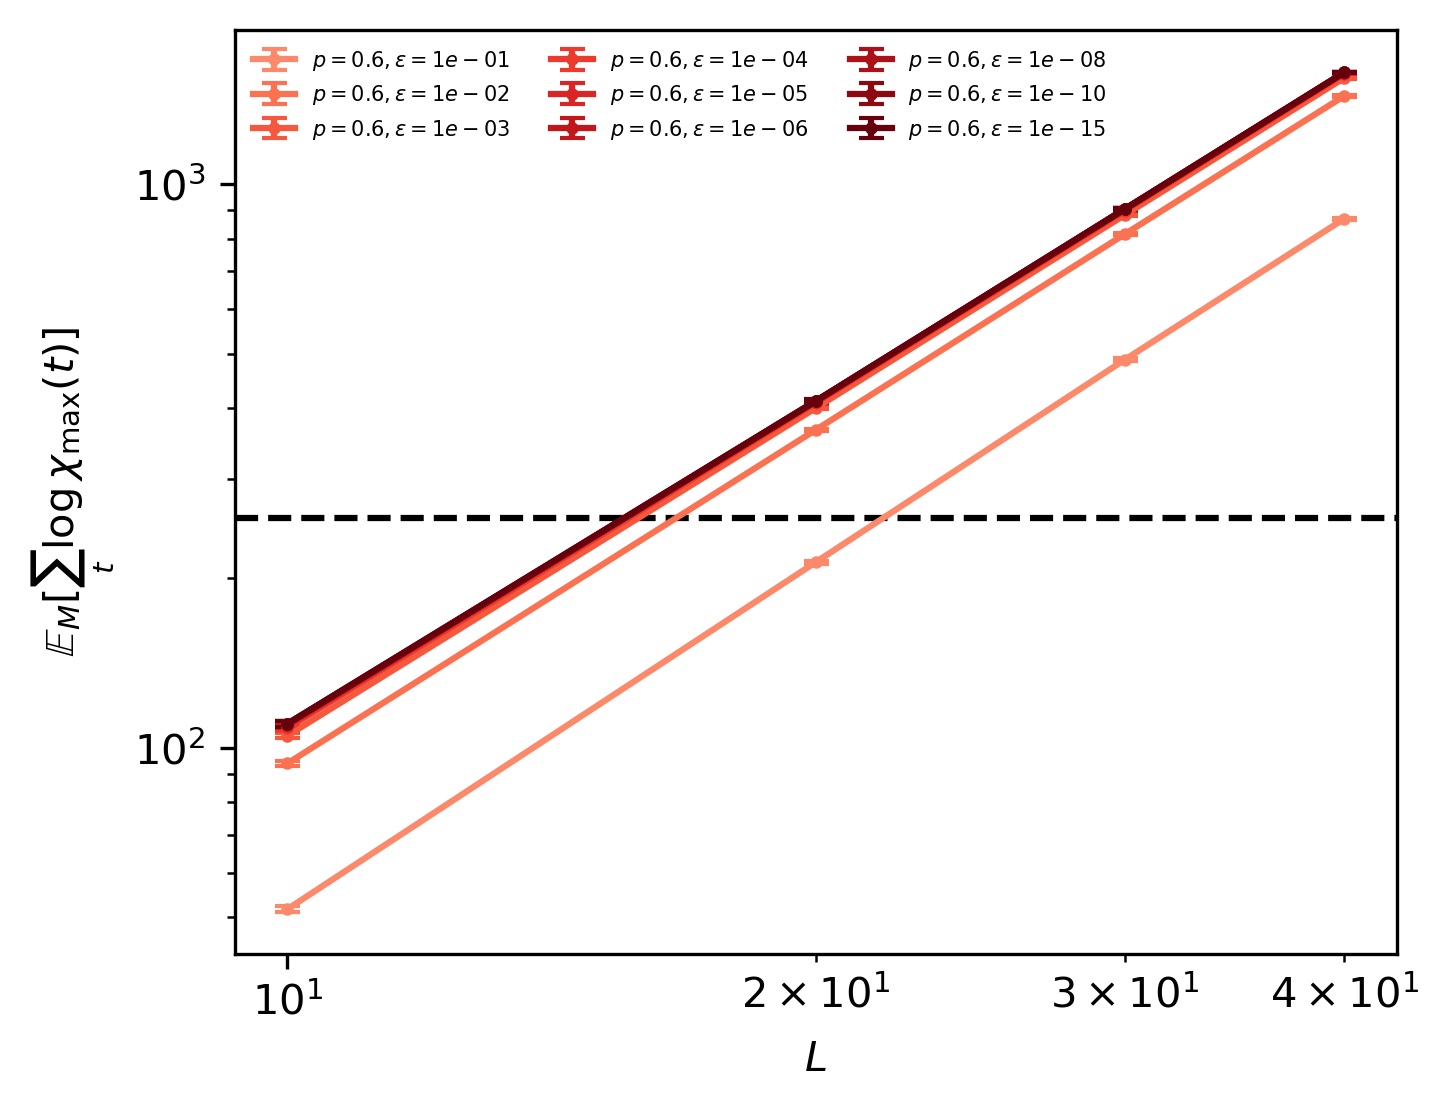

In [145]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.6,]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        integral_maxbond_max_mean_df_ = integral_maxbond_max_mean_df.xs(p,level='p').xs(cutoff,level='cutoff')
        integral_maxbond_max_sem_df_ = integral_maxbond_max_sem_df.xs(p,level='p').xs(cutoff,level='cutoff')
        L_list_ = integral_maxbond_max_mean_df_.index.get_level_values('L')
        ax.errorbar(L_list_,integral_maxbond_max_mean_df_.values.flatten(),yerr=integral_maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},\epsilon={cutoff:.0e}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathbb{E}_M[\sum_t\log\chi_{\max}(t)]$')

ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=5,frameon=False,ncols=3)

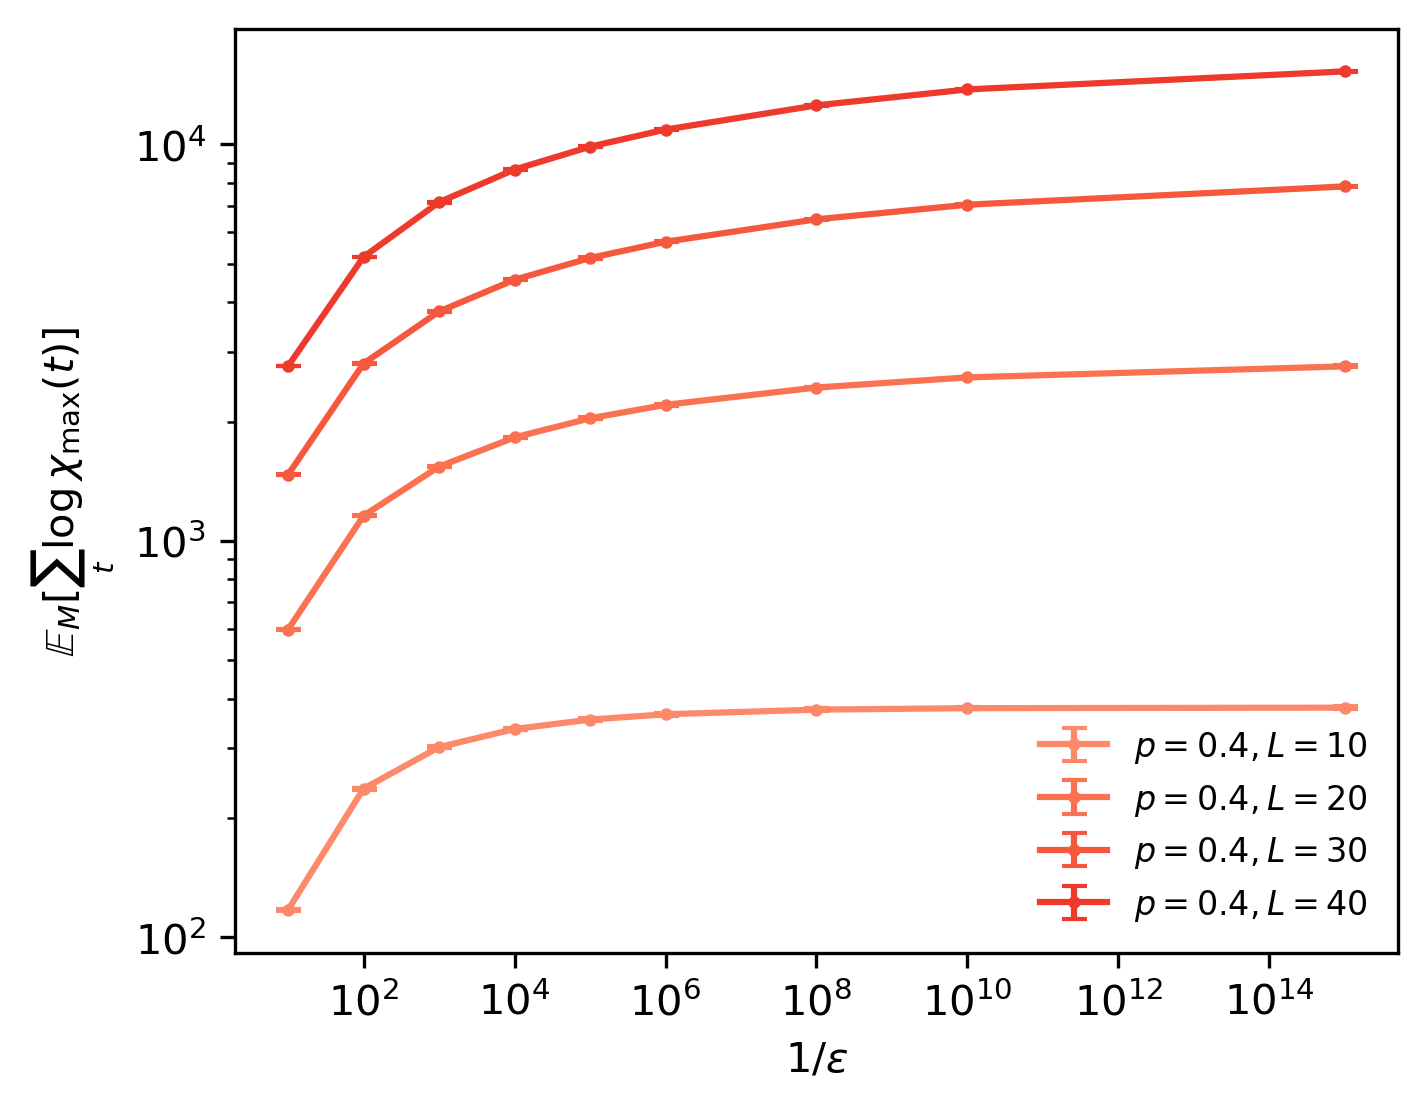

In [153]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,p in enumerate([0.4]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for L in L_list:
        integral_maxbond_max_mean_df_ = integral_maxbond_max_mean_df.xs(p,level='p').xs(L,level='L')
        integral_maxbond_max_sem_df_ = integral_maxbond_max_sem_df.xs(p,level='p').xs(L,level='L')
        cutoff_list = integral_maxbond_max_mean_df_.index.get_level_values('cutoff')
        ax.errorbar(1/cutoff_list,integral_maxbond_max_mean_df_.values.flatten(),yerr=integral_maxbond_max_sem_df_.values.flatten(),fmt='.-',label=fr'$p={p:.1f},L={L}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$1/\epsilon$')
ax.set_ylabel(r'$\mathbb{E}_M[\sum_t\log\chi_{\max}(t)]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=8,frameon=False)

## Successful rate

### By success i mean, $\chi(i,t)$ should be always smaller than cap 256

In [332]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)
bondcap=(2<<7)
success_mean_dict = {}
success_sem_dict = {}
for idx,L in enumerate([10,20,30,40]):
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('maxbond',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in tqdm(cutoff_list):
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                t_mean = np.all(np.stack(dataset)<bondcap,axis=(1,2)).mean(axis=0)
                t_sem = np.all(np.stack(dataset)<bondcap,axis=(1,2)).std(axis=0)/np.sqrt(len(dataset))

                success_mean_dict[(L,cutoff,p)] = t_mean
                success_sem_dict[(L,cutoff,p)] = t_sem

                

success_mean_df=convert_pd(success_mean_dict,names=['L','cutoff','p'])
success_sem_df=convert_pd(success_sem_dict,names=['L','cutoff','p'])

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 6/9 [00:10<00:05,  1.68s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:18<00:00, 15.35s/it]


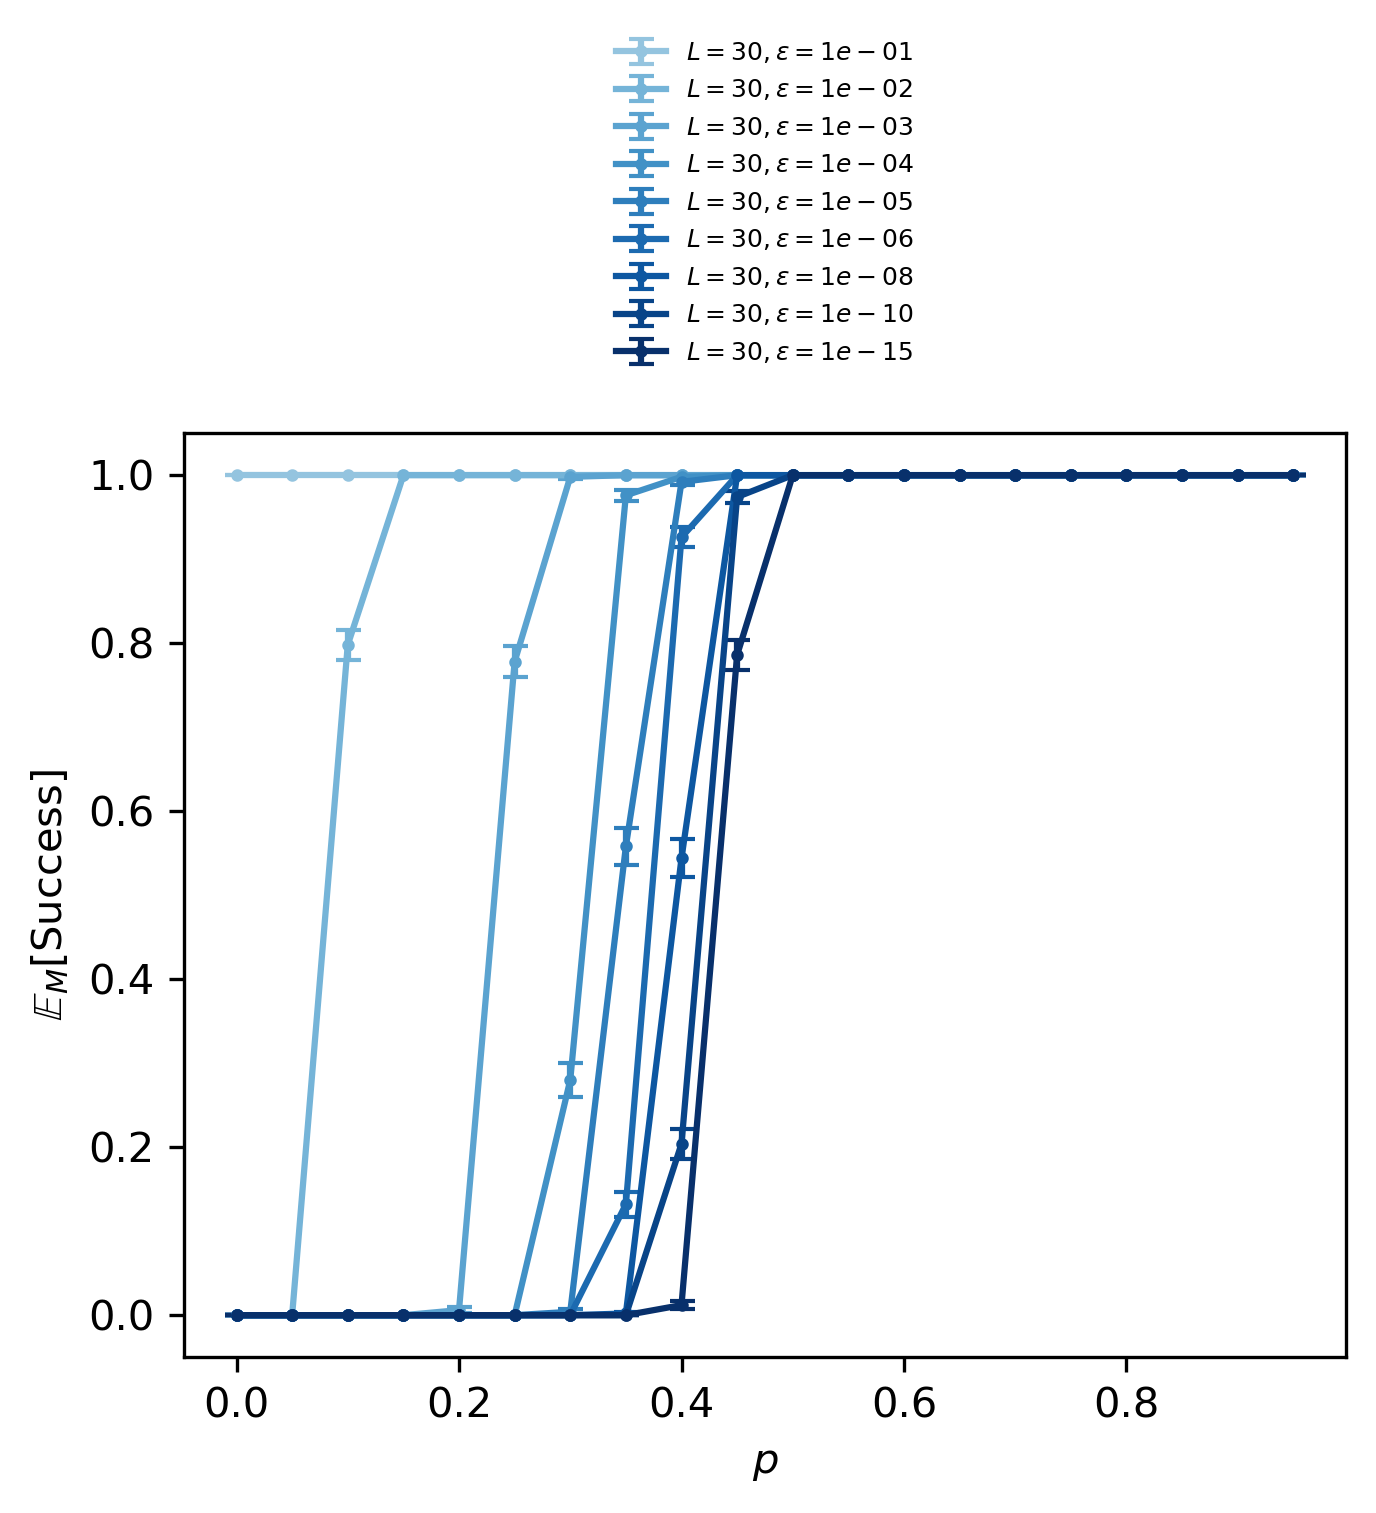

In [340]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))
L_list_=[30,]
for idx,L in enumerate(L_list_):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        success_mean_df_ = success_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        success_sem_df_ = success_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = success_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,success_mean_df_.values.flatten(),yerr=success_sem_df_.values.flatten(),fmt='.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap),capsize=3,markersize=4)
# ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[\rm Success]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(L_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

Index([ 0.0, 0.05,  0.1, 0.15,  0.2, 0.25,  0.3, 0.35,  0.4, 0.45,  0.5, 0.55,
        0.6, 0.65,  0.7, 0.75,  0.8, 0.85,  0.9, 0.95],
      dtype='float64', name='p')

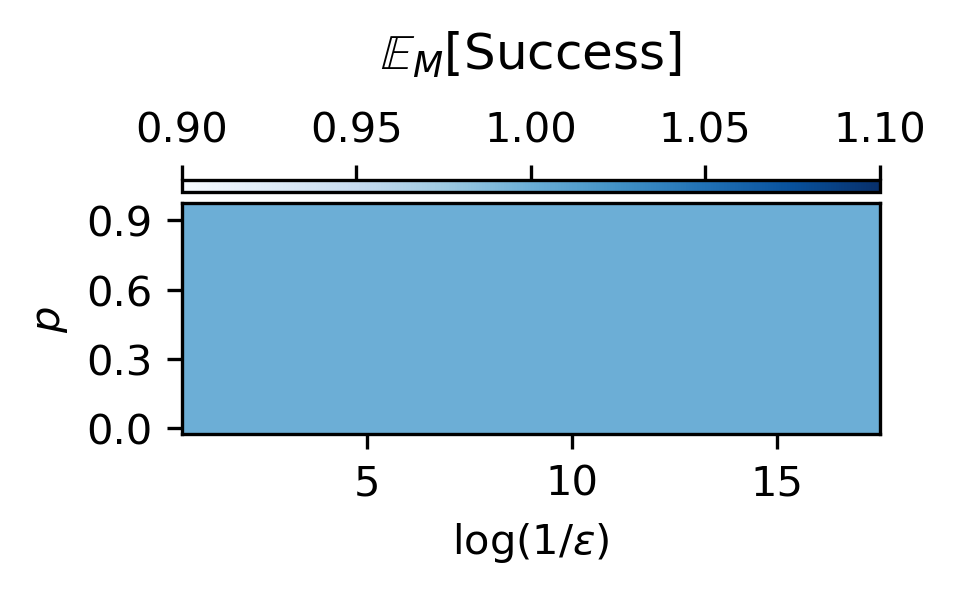

In [393]:
p_list=success_mean_df.index.get_level_values('p').unique()
ε_inv=np.log10(1/np.array(cutoff_list))
L=10

fig,ax=plt.subplots(1,1,figsize=(3,1))
data_=np.stack(success_mean_df.xs(L,level='L')['observations']).reshape((len(cutoff_list),len(p_list))).T

im=ax.pcolormesh(ε_inv,p_list,data_,cmap='Blues')

axins = ax.inset_axes([0, 1.05, 1, 0.05]) 
cb = plt.colorbar(im, cax=axins, orientation='horizontal')
axins.xaxis.set_ticks_position('top')
axins.xaxis.set_label_position('top')
axins.set_title(r'$\mathbb{E}_M[\rm Success]$', pad=10)

ax.set_xlabel(r'$\log(1/\epsilon)$')
ax.set_ylabel(r'$p$')
ax.set_yticks([0,.3,.6,.9])

## O 

In [394]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

O_mean_dict = {}
O_sem_dict = {}
for idx,L in enumerate([10,20,30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('O',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in cutoff_list:
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                O_mean = np.stack(dataset).mean(axis=0)
                O_sem = np.stack(dataset).std(axis=0)/np.sqrt(len(dataset))

                O_mean_dict[(L,cutoff,p)] = O_mean
                O_sem_dict[(L,cutoff,p)] = O_sem

                

O_mean_df=convert_pd(O_mean_dict,names=['L','cutoff','p'])
O_sem_df=convert_pd(O_sem_dict,names=['L','cutoff','p'])

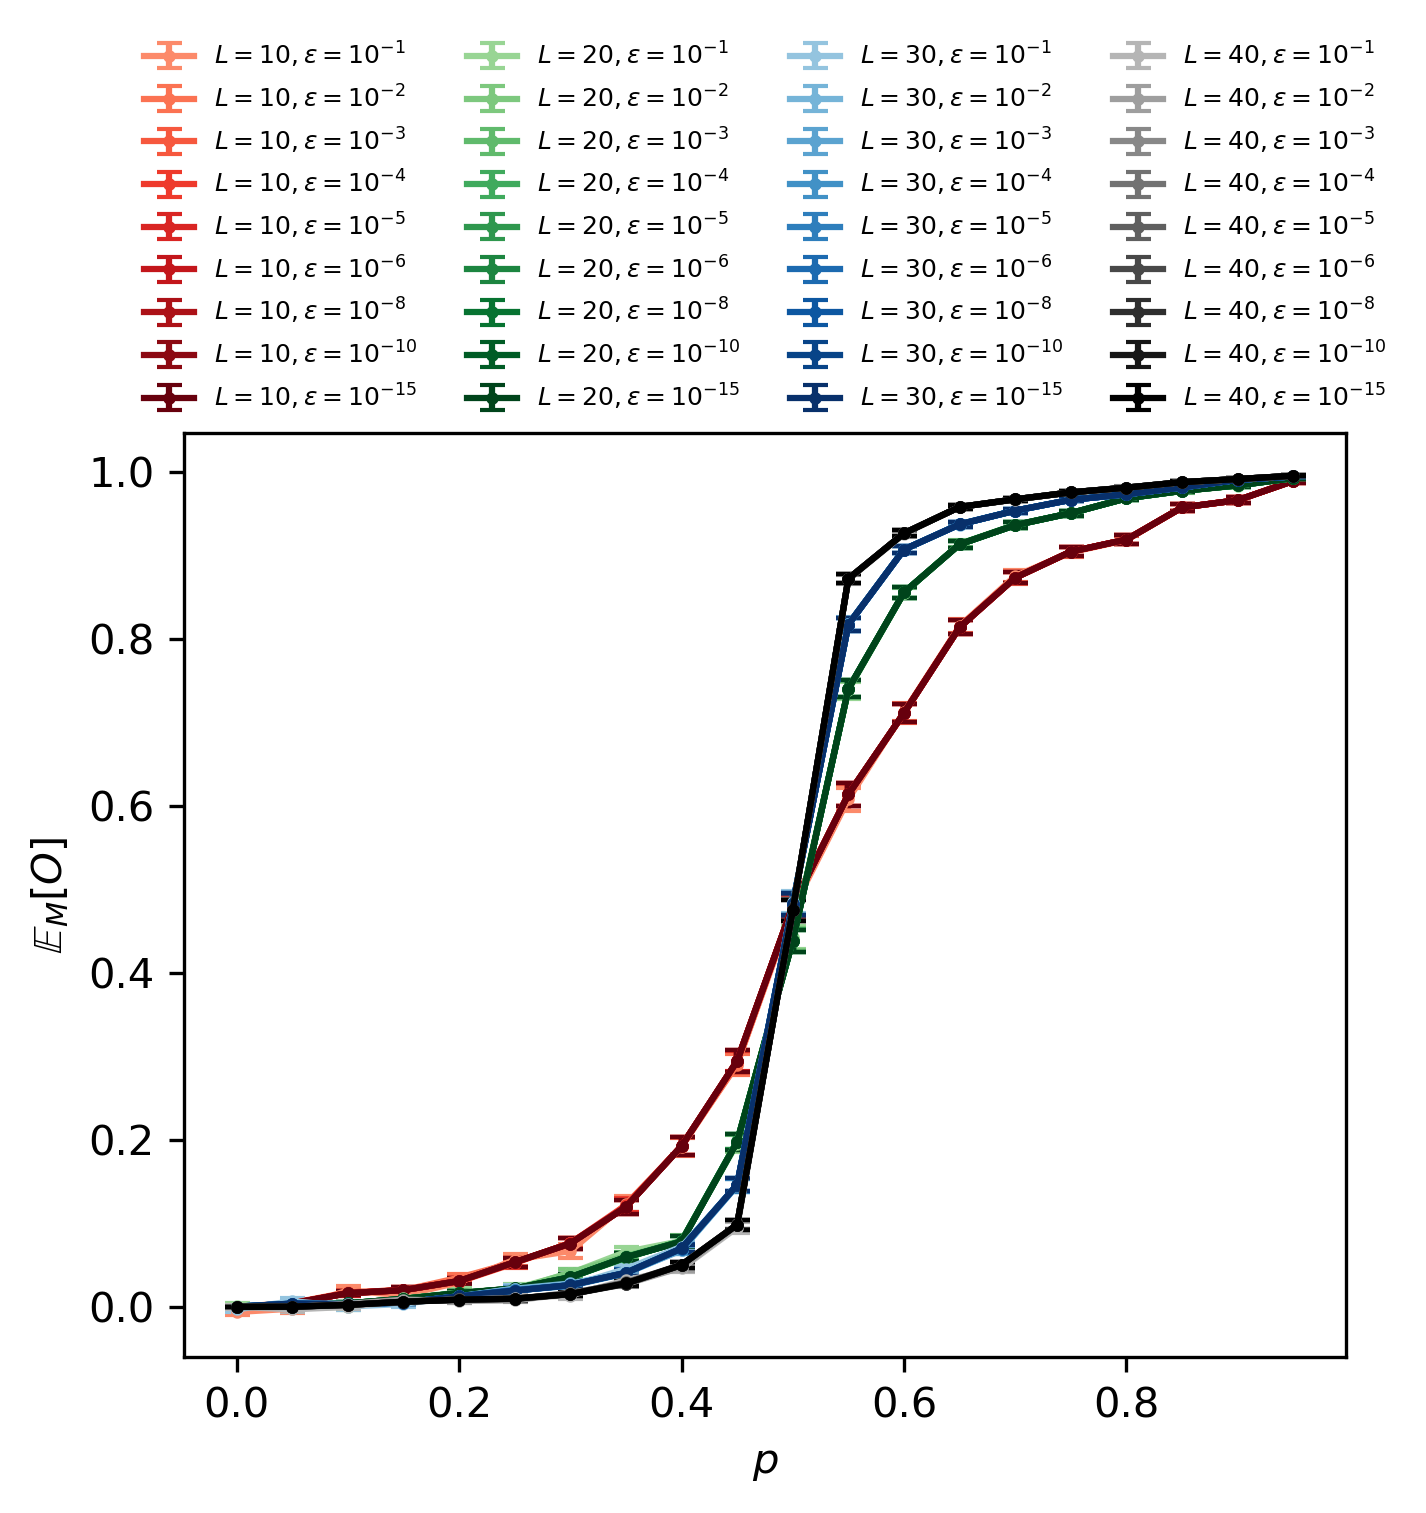

In [400]:
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
fig,ax=plt.subplots(1,1,figsize=(5,4))

for idx,L in enumerate([10,20,30,40]):
    cmap = iter(cmap_list[L//10-1]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        O_mean_df_ = O_mean_df.xs(L,level='L').xs(cutoff,level='cutoff')
        O_sem_df_ = O_sem_df.xs(L,level='L').xs(cutoff,level='cutoff')
        p_list_ = O_mean_df_.index.get_level_values('p')
        ax.errorbar(p_list_,O_mean_df_.values.flatten(),yerr=O_sem_df_.values.flatten(),fmt='.-',label=fr'$L={L},\epsilon=10^{{ {np.log10(cutoff):.0f}}}$',color = next(cmap),capsize=3,markersize=4)
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M[O]$')
# ax.axhline(2<<7,linestyle='--',color='black')
ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(L_list_),bbox_to_anchor=(0.5, 1+(len(cutoff_list))*0.05))

In [401]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)

O_mean_dict = {}
# O_sem_dict = {}
for idx,L in enumerate([10,20,30,40,]):
        
        dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('O',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
        for cutoff in cutoff_list:
            dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
            for p in p_list:
                dataset = dataset_cutoff.xs(p,level='p_ctrl')
                O_mean = np.stack(dataset)
                # O_sem = np.stack(dataset).std(axis=0)/np.sqrt(len(dataset))

                O_mean_dict[(L,cutoff,p)] = O_mean
                # O_sem_dict[(L,cutoff,p)] = O_sem

                

O_mean_df=convert_pd(O_mean_dict,names=['L','cutoff','p'])
# O_sem_df=convert_pd(O_sem_dict,names=['L','cutoff','p'])

In [429]:
delta_cutoff=np.diff(-(np.log10(cutoff_list)))

In [434]:
data_=np.stack(O_mean_df.xs(L,level='L').xs(p,level='p')['observations'])
np.abs(data_[:-1]-data_[1:]).mean(axis=-1)/delta_cutoff

array([2.26701461e-02, 7.84859025e-03, 2.59006098e-03, 5.71616196e-04,
       2.91762729e-04, 2.04796879e-05, 1.17118999e-06, 3.92232346e-08])

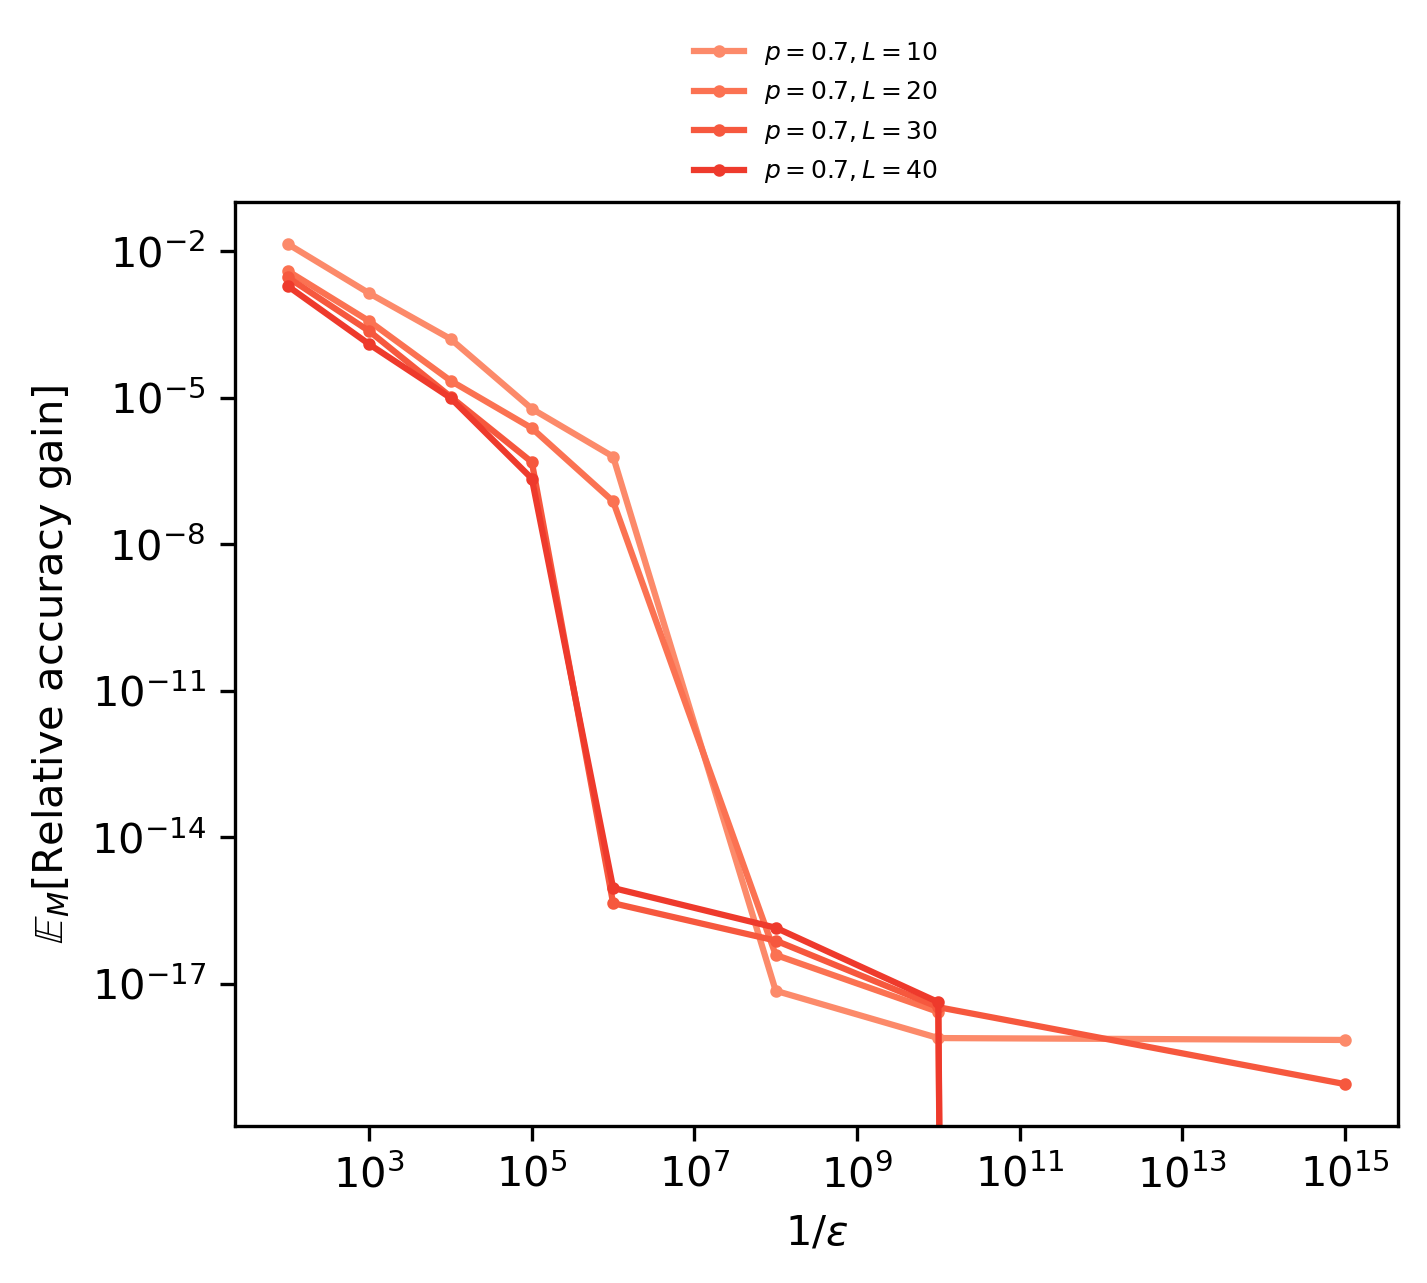

In [468]:

# L=40
# p=.0
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues,plt.cm.Greys]
cutoff_list = np.array(params_list[0][1]['cutoff'])
fig,ax=plt.subplots(1,1,figsize=(5,4))
p_list_=[0.7,]
L_list = [10,20,30,40,]
# 
for idx,p in enumerate(p_list_):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for L in L_list:
        data_=np.stack(O_mean_df.xs(L,level='L').xs(p,level='p')['observations'])
        # y=np.abs(data_[:-1]-data_[1:]).mean(axis=-1)/delta_cutoff
        y=np.abs(np.abs(data_[:-1]/data_[1:])-1).mean(axis=-1)/delta_cutoff
        # y=np.abs(data_[:-1]-data_[1:]).std(axis=-1)/delta_cutoff

        ax.errorbar(1/cutoff_list[1:],y,fmt='.-',label=fr'$p={p:.1f},L={L}$',color = next(cmap),capsize=3,markersize=4)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$1/\epsilon$')
ax.set_ylabel(r'$\mathbb{E}_M[\rm Relative~accuracy~gain]$')

ax.legend(fontsize=6,loc='upper center',frameon=False,ncols=len(p_list_),bbox_to_anchor=(0.5, 1+(len(L_list))*0.05))

In [ ]:
# plt.plot(-np.log10(cutoff_list),np.stack(O_mean_df.xs(L,level='L').xs(p,level='p')['observations'])[:,0],'.-')


In [411]:
O_mean_df.xs((10,:,0))['observations']

SyntaxError: invalid syntax (2126317112.py, line 1)

In [407]:
O_mean_df.xs((10,1e-2,0))

observations    [0.007298542291410226, -0.004022349908392076, ...
Name: (10, 0.01, 0.0), dtype: object

In [408]:
O_mean_df.xs((10,1e-10,0))

observations    [0.006267527623988444, -0.007688010471394004, ...
Name: (10, 1e-10, 0.0), dtype: object

In [409]:
O_mean_df.xs((10,1e-15,0))

observations    [0.006267527623988444, -0.007688010471394004, ...
Name: (10, 1e-15, 0.0), dtype: object

## Try to rerun : any point that hit 256

In [360]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
maxdim=params_list[0][1]['maxdim'][0]
cutoff_list = params_list[0][1]['cutoff']
p_list=np.round(params_list[0][1]['p_ctrl'],2)
bondcap=(2<<7)
rerun_dict ={}
for idx,L in enumerate([10,20,30,40]):
    dataset_L = df_MPS_0_T['observations'].xs(maxdim,level='maxdim').xs('maxbond',level='Metrics').xs(L,level='L').xs(0,level='p_proj')
    for cutoff in tqdm(cutoff_list):
        dataset_cutoff = dataset_L.xs(cutoff,level='cutoff')
        for p in p_list:
            dataset = dataset_cutoff.xs(p,level='p_ctrl')
            sC_index, = np.where(~np.all(np.stack(dataset)<bondcap,axis=(1,2)))
            if len(sC_index)>0:
                rerun_dict[(L,cutoff,p)]=sC_index

                

 56%|████████████████████████████████████████████████████████████████████████▊                                                          | 5/9 [00:15<00:12,  3.07s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:13<00:00,  8.15s/it]


In [ ]:
np.all(np.stack(dataset)<bondcap,axis=(1,2))

In [357]:
sC_index

(array([], dtype=int64),)

In [354]:
len(sC)

1

In [362]:
rerun_df=convert_pd(rerun_dict,names=['L','cutoff','p'])


In [365]:
rerun_df.xs(20,level='L')

observations
cutoff       p                                                      
1.000000e-02 0.00  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
             0.05  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
             0.10  [2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17,...
             0.15                                              [259]
1.000000e-03 0.00  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
...                                                              ...
1.000000e-15 0.25  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
             0.30  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
             0.35  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
             0.40  [1, 2, 7, 8, 12, 14, 15, 16, 17, 19, 20, 22, 2...
             0.45  [24, 41, 63, 72, 93, 107, 108, 120, 127, 142, ...

[67 rows x 1 columns]

In [ ]:
f=[]
L=40
p_proj,sm,maxdim=0,0,512
rerun_df_ = rerun_df.xs(L,level='L')
for (cutoff,p_ctrl),row in rerun_df_.iterrows():
    for sC in row['observations']:
        str_=f"{p_ctrl:.3f},{p_proj:.3f},{L},{sC},{sm},{maxdim},{cutoff:.1e}"
        f.append(str_)

In [497]:
linewidth=400
count=0
total_string = []
string = ''
for line in f:
    string = string + ',' + line.strip()
    count+=1
    if count>=linewidth:
        count=0
        total_string.append(string[1:])
        string= ''
# Add the remaining part if it exists
if string:
    total_string.append(string[1:])

In [ ]:
with open(f'params_CT_MPS_0_C_m_T_L{L}_series.txt','w') as f:
    f.write('\n'.join(total_string))

In [489]:
3600/262 *96 *4

5276.335877862595

In [496]:
3600/2990 *96 *4

462.34113712374585

In [ ]:
7560/2990 *96 *4

462.34113712374585

In [ ]:
print(string)

## rererun

In [42]:
import os

def check_missing_params(params_txt, data_dir='./'):
    """
    params_txt: path to your params_CT_MPS_…txt
    data_dir:  directory where MPS_(*).json files live
    """
    # read and split all tokens
    with open(params_txt) as f:
       lines = f.read().splitlines()
    tok = []
    for ln in lines:
        if not ln.strip(): 
            continue
        tok.extend([x for x in ln.split(',') if x])
    f = []
    print(len(tok)/7)
    # iterate every 7 tokens
    for i in range(0, len(tok), 7):

        p_ctrl, p_proj, L, sC, sm, maxdim, cutoff = tok[i:i+7]
        # cast
        p_ctrl_f = float(p_ctrl)
        p_proj_f = float(p_proj)
        L_i       = int(L)
        sC_i      = int(sC)
        sm_i      = int(sm)
        maxdim_i  = int(maxdim)
        cutoff_f  = float(cutoff)
        # build filename (nu=0,de=1)
        fn = (
            f"MPS_(0,1)_L{L_i}"
            f"_pctrl{p_ctrl_f:.3f}"
            f"_pproj{p_proj_f:.3f}"
            f"_sC{sC_i}"
            f"_sm{sm_i}"
            f"_maxdim{maxdim_i}"
            f"_cutoff{cutoff_f:.1e}.json"
        )
        
        full = os.path.join(data_dir, fn)
        if not os.path.exists(full):
            # print missing 7‐tuple
            # print(fn)
            f.append(f"{p_ctrl_f:.3f},{p_proj_f:.3f},{L_i},{sC_i},{sm_i},{maxdim_i},{cutoff_f:.1e}")
    return f

In [43]:
L=40

In [44]:
files=check_missing_params(f'params_CT_MPS_0_C_m_T_L{L}_series.txt')

28522.0


In [45]:
len(files)

3041

In [18]:
25996-11842

14154

In [34]:
28016-22404

5612

In [11]:
28522-3041

25481

In [46]:
linewidth=96
count=0
total_string = []
string = ''
for line in files:
    string = string + ',' + line.strip()
    count+=1
    if count>=linewidth:
        count=0
        total_string.append(string[1:])
        string= ''
# Add the remaining part if it exists
if string:
    total_string.append(string[1:])

In [47]:
with open(f'params_CT_MPS_0_C_m_T_L{L}_series_2.txt','w') as f:
    f.write('\n'.join(total_string))

In [34]:
len(total_string)

36

In [12]:
len(f)

500

In [36]:
(3600/2990*96) *4

462.34113712374585

In [41]:
(3600/7560*96) *4

182.85714285714283

# Legacy

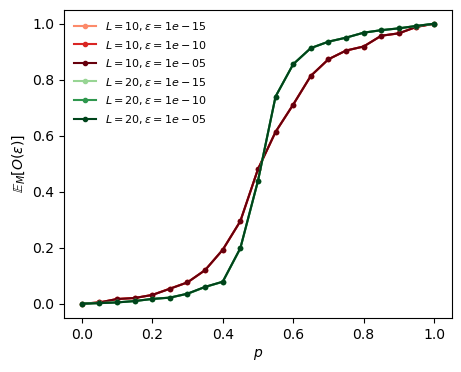

In [9]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=2**13
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues]
cutoff_list = [1e-15,1e-10,1e-5]
for idx,L in enumerate([10,20]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        O_list=[]
        p_list_=[]
        for p in p_list:
            # try:
            O=np.stack(df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).mean()
            p_list_.append(p)
            O_list.append(O)
            # except:
            #     pass
        ax.plot(p_list_,O_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
# ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M [O(\epsilon)]$')

# ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

In [126]:
p=0.1
L=10
cutoff = 1e-5
(df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).sort_index(level='sC')

sm  sC   p_proj
0   0    0.0       -0.004558274595816303
    1    0.0        -0.03729218460092394
    2    0.0          0.1260042657463911
    3    0.0       -0.040253425091019764
    4    0.0       -0.010537753896863289
                           ...          
    495  0.0        0.020050608910366502
    496  0.0        0.011938877348414912
    497  0.0        -0.05279317843283828
    498  0.0         0.05727500334097861
    499  0.0        -0.03041658906607565
Name: observations, Length: 500, dtype: object

In [10]:
p=0.1
L=10
cutoff=1e-15
(df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).sort_index(level='sC')

sm  sC   p_proj
0   0    0.0       -0.0041198070862553645
    1    0.0         -0.03741550917520097
    2    0.0           0.1261808824893993
    3    0.0         -0.04063009354343034
    4    0.0        -0.010798933949134424
                            ...          
    495  0.0         0.019985760314326344
    496  0.0         0.011740046699106974
    497  0.0         -0.05305816808317391
    498  0.0         0.057240960878366165
    499  0.0        -0.030329875507481126
Name: observations, Length: 500, dtype: object

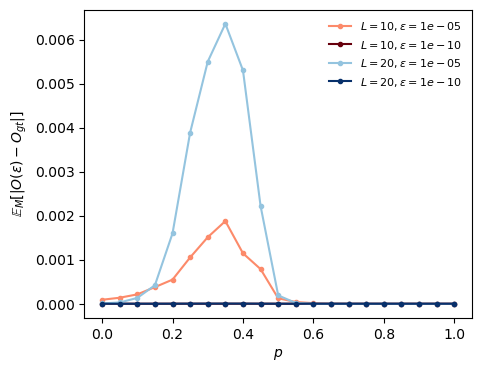

In [11]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=2**13
cmap_list = [plt.cm.Reds,plt.cm.Blues,plt.cm.Blues]
cutoff_list = [1e-5,1e-10,]
cutoff_min=1e-15
for idx,L in enumerate([10,20]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        delta_O_list=[]
        p_list_=[]
        for p in p_list:
            # try:
            O=(df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations'])
            O_gt = (df_MPS_0_T.xs('O',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff_min,level='cutoff').xs(maxdim,level='maxdim')['observations'])
            p_list_.append(p)
            delta_O_list.append((np.abs(O-O_gt)).mean())
            # except:
            #     pass
        ax.plot(p_list_,delta_O_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
# ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\mathbb{E}_M [|O(\epsilon)-O_{gt}|]$')
# ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

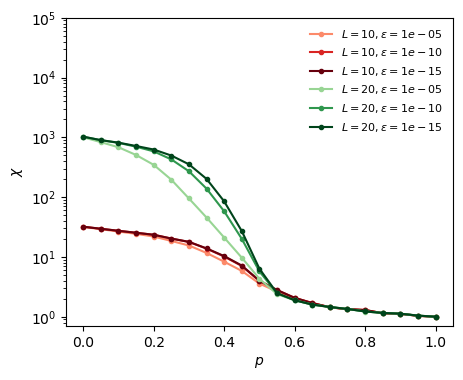

In [12]:
Op_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=2**13
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues]
cutoff_list = [1e-5,1e-10,1e-15]

for idx,L in enumerate([10,20]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_list=[]
        p_list_=[]
        for p in p_list:
            # try:
            maxbond=np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).mean()
            p_list_.append(p)
            maxbond_list.append(maxbond)
            # except:
            #     pass
        ax.plot(p_list_,maxbond_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

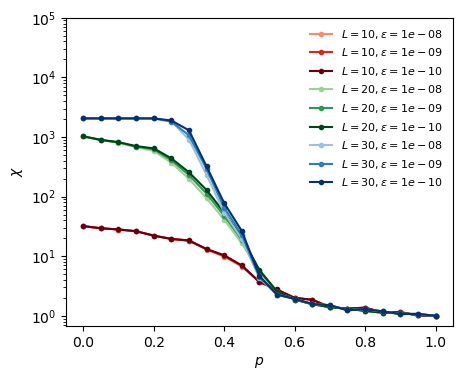

In [ ]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=2048
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues]
cutoff_list = [1e-8,1e-9,1e-10]
for idx,L in enumerate([10,20]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_list=[]
        p_list_=[]
        for p in p_list:
            try:
                maxbond=np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).mean()
                p_list_.append(p)
                maxbond_list.append(maxbond)
            except:
                pass
        ax.plot(p_list_,maxbond_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

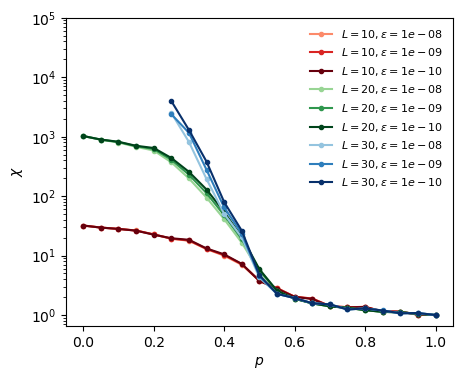

In [33]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
maxdim=4096
cmap_list = [plt.cm.Reds,plt.cm.Greens,plt.cm.Blues]
cutoff_list = [1e-8,1e-9,1e-10]
for idx,L in enumerate([10,20,30]):
    cmap = iter(cmap_list[idx]( np.linspace(0.4,1,len(cutoff_list)) ))
    for cutoff in cutoff_list:
        maxbond_list=[]
        p_list_=[]
        for p in p_list:
            try:
                maxbond=np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(cutoff,level='cutoff').xs(maxdim,level='maxdim')['observations']).mean()
                p_list_.append(p)
                maxbond_list.append(maxbond)
            except:
                pass
        ax.plot(p_list_,maxbond_list,'.-',label=fr'$L={L},\epsilon={cutoff:.0e}$',color = next(cmap))
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend(fontsize=8,frameon=False)

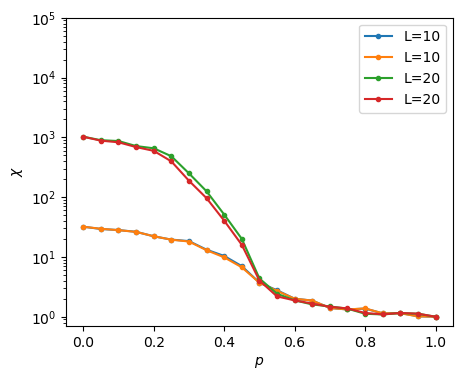

In [29]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
for L in [10,20]:
    maxbond_list=[np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(1e-10,level='cutoff').xs(2048,level='maxdim')['observations']).mean() for p in p_list]
    ax.plot(p_list,maxbond_list,'.-',label=f'L={L}')

    maxbond_list=[np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L').xs(1e-8,level='cutoff').xs(2048,level='maxdim')['observations']).mean() for p in p_list]
    ax.plot(p_list,maxbond_list,'.-',label=f'L={L}')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend()

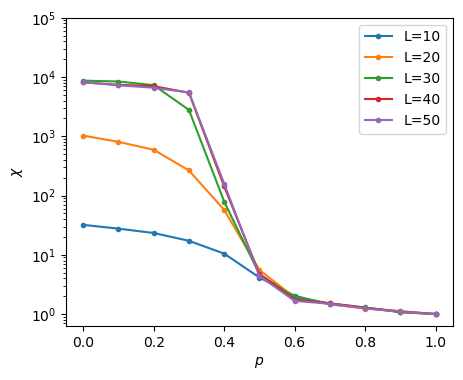

In [17]:
p_list = df_MPS_0_T.index.get_level_values('p_ctrl').unique().sort_values()
fig,ax=plt.subplots(1,1,figsize=(5,4))
for L in [10,20,30,40,50]:
    maxbond_list=[np.stack(df_MPS_0_T.xs('maxbond',level='Metrics').xs(p,level='p_ctrl').xs(L,level='L')['observations']).mean() for p in p_list]
    ax.plot(p_list,maxbond_list,'.-',label=f'L={L}')
ax.set_yscale('log')
ax.set_xlabel(r'$p$')
ax.set_ylabel(r'$\chi$')
ax.set_ylim(None, 1e5)
ax.legend()

In [18]:
print(f"np.complex64: {np.dtype(np.complex64).itemsize} bytes")
print(f"np.complex128 (default np.complex): {np.dtype(np.complex128).itemsize} bytes")
if hasattr(np, 'complex256'):
    print(f"np.complex256: {np.dtype(np.complex256).itemsize} bytes")
else:
    print("np.complex256 not available on this platform")

np.complex64: 8 bytes
np.complex128 (default np.complex): 16 bytes
np.complex256: 32 bytes


In [21]:
np.hstack(df_MPS_0_T.xs('success',level='Metrics')['observations']).sum()

11000

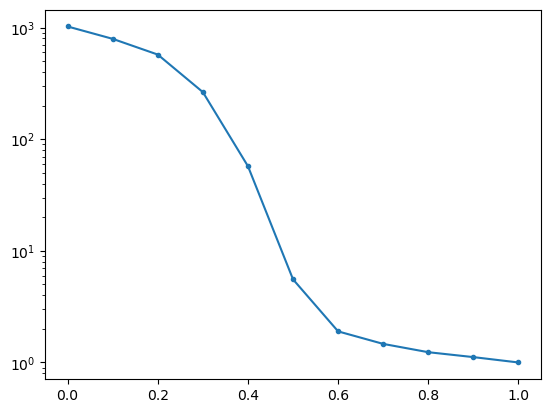

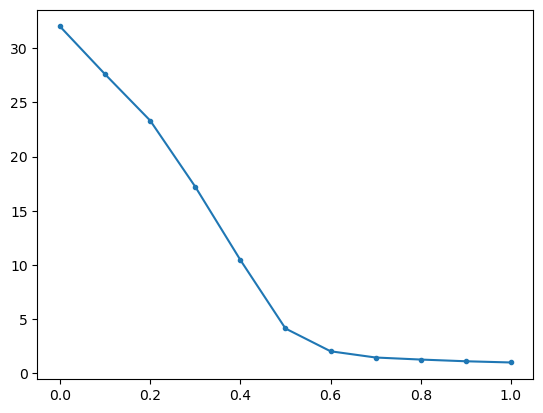

In [ ]:
plt.plot(p_list,maxbond_list,'.-')

In [25]:
p_list

Index([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], dtype='float64', name='p_ctrl')